The article *Crowdsmelling: The Use of Collective Knowledge in Code Smells Detection* defines the following code smells:

1. **Long Method**:
   - Definition: A method that is too large, implementing more than one functionality. It tends to be difficult to understand, extend, and modify. This often means that the method violates the Single Responsibility Principle (SRP), having multiple responsibilities rather than focusing on a single task.
   - Example: A method in a class that contains hundreds of lines of code handling multiple processes (e.g., reading user input, processing data, and generating output all in one method), making it complex to maintain and update【19†source】.

2. **God Class**:
   - Definition: A class that accumulates too many responsibilities, often having a large number of methods and attributes. It tends to have poor cohesion and many dependencies on other classes, which makes it harder to maintain and extend. This code smell also goes against the SRP.
   - Example: A class named `UserManager` that handles all user-related functions such as authentication, profile management, data storage, and logging activities, instead of delegating responsibilities to smaller, more focused classes .

3. **Feature Envy**:
   - Definition: A method that relies heavily on the data and functions of another class rather than its own. It shows more interest in the members of other classes, suggesting that it might be better placed within that other class.
   - Example: A method in `ClassA` that accesses several attributes of `ClassB` to perform calculations, indicating that the method may belong to `ClassB` instead of `ClassA` .

These definitions help to identify common design flaws that can hinder software maintainability, making them targets for refactoring and improvement in the study of software quality.

In [1]:
# some utility functions

import pandas as pd
from functools import wraps
import time
import os
import json
import requests
from google.colab import userdata

from functools import lru_cache

# Some utility keys and functions
LONG_METHOD_KEY = 'long_method'
GOD_CLASS_KEY = 'god_class'
FEATURE_ENVY_KEY = 'feature_envy'

def load_csv_from_google_drive(document_id) -> pd.DataFrame:
  """
  Loads a CSV file from Google Drive into a pandas DataFrame using the document ID.
  Args:
      document_id: The unique ID of the Google Drive document.
  Returns:
      A pandas DataFrame containing the CSV data.
  """

  download_url = f'https://drive.google.com/uc?id={document_id}&export=download'
  print(f"Downloading CSV from Google Drive: {download_url}")
  df = pd.read_csv(download_url)
  return df

def save_dfs_map_as_csv(df_map, output_dir):
  """Saves all DataFrames in a dictionary to CSV files.

  Args:
      df_map: A dictionary where keys are DataFrame names and values are pandas DataFrames.
      output_dir: The directory to save the CSV files to.
  """
  # if output_id doesn't exist, create it
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  for df_key, df in df_map.items():
    if not isinstance(df, pd.DataFrame):
      print(f"* Value for key '{df_key}' is not a pandas DataFrame. Ignoring it.")
      continue
    csv_filename = os.path.join(output_dir, f"{df_key}.csv")
    df.to_csv(csv_filename, index=False)
    print(f"DataFrame '{df_key}' saved to '{csv_filename}'.")


def load_dfs_map_from_csv(csv_dir: str, df_map: dict):
  """
  Loads DataFrames from CSV files and updates the code_smells_df_map.

  Args:
      csv_dir: The directory containing the CSV files.
      df_map: A dictionary where keys are DataFrame names and values are pandas DataFrames.
  """
  # if output_id doesn't exist, return without do nothing
  if not os.path.exists(csv_dir):
    print(f"Directory '{csv_dir}' doesn't exist. Nothing to load.")
    return
  for filename in os.listdir(csv_dir):
      if filename.endswith(".csv"):
          code_smell_name = filename[:-4]  # Remove the .csv extension
          csv_path = os.path.join(csv_dir, filename)
          df = pd.read_csv(csv_path)
          df_map[code_smell_name] = df
          print(f"Loaded DataFrame '{code_smell_name}' from '{csv_path}'.")

def load_and_save_on_disk(path: str, data_map: dict):
  """ Decorator to load and save the data on disk. """
  def decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
      load_dfs_map_from_csv(csv_dir=path, df_map=data_map)
      result = func(*args, **kwargs)
      save_dfs_map_as_csv(df_map=data_map, output_dir=path)
      return result
    return wrapper
  return decorator


def estimate_number_of_tokens(_messages):
    """
    Estimates the number of tokens for the given messages.
    Args:
        _messages: The list of messages to estimate tokens for.
    Returns:
        The estimated number of tokens.
    """
    # counting the approximate number of tokens for the messages
    total_chars = 0
    for msg in _messages:
        total_chars += len(msg["content"])
    # estimated tokens per char is 0.25
    estimated_tokens = total_chars * 0.25
    # To avoid limits over time, we consider increasing the max tokens
    considered_max_tokens = int(estimated_tokens * 1.5)
    # print(f"Estimated number of tokens: {considered_max_tokens}")
    return min(considered_max_tokens, 16384)

def retry_until_true(max_retries=5, delay=1):
    """
    A decorator that retries the function until true is returned.

    Args:
    - max_retries (int): Maximum number of retries.
    - delay (int): Delay in seconds between retries.

    Returns:
    - Wrapper function with retry logic.
    """
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            retries = 0
            while retries < max_retries:
                result = func(*args, **kwargs)

                # Check the condition
                if result:
                    print("Condition satisfied. Exiting retry loop.")
                    return result

                print(f"Condition not met. Retrying {retries + 1}/{max_retries}...")
                retries += 1
                time.sleep(delay)

            print("Max retries reached. Exiting.")
            return result

        return wrapper
    return decorator

def run_if_condition(run_func, test_func, *args, **kwargs):
    """
    Runs the `run_func` only if `test_func` returns True.

    Args:
        run_func (function): The function to be run conditionally.
        test_func (function): The function to check the condition.
        *args: Positional arguments to pass to both functions.
        **kwargs: Keyword arguments to pass to both functions.

    Returns:
        The result of `run_func` if `test_func` is True, otherwise None.
    """
    if test_func(*args, **kwargs):
        print(f"Condition satisfied. Running '{run_func.__name__}'.")
        return run_func(*args, **kwargs)
    else:
        print(f"Condition not satisfied. Skipping '{run_func.__name__}'.")
        return None

@lru_cache(maxsize=250)
def call_openai_api(user_msg, context=None, model="gpt-4o-mini",
                    temperature=None, top_p=None, frequency_penalty=None,
                    presence_penalty=None,
                    response_as_json=True,
                    ):
    """
    Calls the OpenAI API with the given prompt.

    Args:
        user_msg: The prompt to send to the API.
        context: The context to send to the API.
        model: The model to use for the API call.
        temperature: The temperature to use for the API call.

    Returns:
        The response from the API.
    """
    api_key = userdata.get('OPENAI_TOKEN')

    if not api_key:
        raise ValueError("API key not found. Please set 'OPENAI_TOKEN' in the userdata.")

    api_url = "https://api.openai.com/v1/chat/completions"

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    # Define the messages to send to the model
    _messages = []

    if context is not None:
        _messages.append({
            "role": "system",
            "content": context,
        })


    # Adding the user message
    _messages.append(
        {
            "role": "user",
            "content": user_msg,
        }
    )

    data = {
        "model": model,
        "messages": _messages,
        "max_tokens": estimate_number_of_tokens(_messages),
    }

    if temperature is not None:
        data["temperature"] = temperature

    if top_p is not None:
        data["top_p"] = top_p

    if frequency_penalty is not None:
        data["frequency_penalty"] = frequency_penalty

    if presence_penalty is not None:
        data["presence_penalty"] = presence_penalty

    if response_as_json:
        data["response_format"] = {"type": "json_object"}

    response = requests.post(api_url, headers=headers, json=data, timeout=180)
    response.raise_for_status()

    return response.json()


##**Methodologic Decisions**

-
- Due to the low number of rows from systems other than "jasml-0.10," we decided to use only the data corresponding to the "jasml-0.10" system.

# Data Preparation

## Loading databases

In [2]:
# Long Method code smell dataset
# "long-method-2020+2019+2018.csv"
# Full link on Google Drive:
# https://drive.google.com/file/d/1-2e7WrESm2TC59ZLyygQS6FfWKYsF9N1/view?usp=drive_link
long_method_2020_2019_2018_csv = '1-2e7WrESm2TC59ZLyygQS6FfWKYsF9N1'
long_method_raw_data = load_csv_from_google_drive(long_method_2020_2019_2018_csv)

# God Class code smell dataset
# "god-class-2020+2019+2018.csv"
# Full link on Google Drive:
# https://drive.google.com/file/d/1hMlj6g_cQBuEyBo2NdppRT2ULW876ju9/view?usp=sharing
god_class_2020_2019_2018_csv = '1hMlj6g_cQBuEyBo2NdppRT2ULW876ju9'
god_class_raw_data = load_csv_from_google_drive(god_class_2020_2019_2018_csv)

# Feature Envy code smell dataset
# "feature-envy-2020+2019+2018.csv"
# Full link on Google Drive:
# https://drive.google.com/file/d/1FqQX2acoDGUAmj6i3VU4jKG4-ZbiG6e5/view?usp=drive_link
feature_envy_2020_2019_2018_csv = '1FqQX2acoDGUAmj6i3VU4jKG4-ZbiG6e5'
feature_envy_raw_data = load_csv_from_google_drive(feature_envy_2020_2019_2018_csv)

# initing the control map
code_smells_df_map = {
    "raw_data": {
        LONG_METHOD_KEY: long_method_raw_data,
        GOD_CLASS_KEY: god_class_raw_data,
        FEATURE_ENVY_KEY: feature_envy_raw_data
        },
    # This entry will retain the target col name for each data frame
    "targets": {
        LONG_METHOD_KEY: 'is_long_method',
        GOD_CLASS_KEY: 'is_god_class',
        FEATURE_ENVY_KEY: 'is_feature_envy'
      },
    # This entry will retain the data frames following the cleaning,
    # transformation and aggregation process.
    # initilizing it with a copy of the raw data
    "ground_truth_data": {
    },
  }

# global variables to make easy the access to code smells map
RAW_DATA_MAP = code_smells_df_map["raw_data"]
TARGETS_MAP = code_smells_df_map["targets"]
GROUND_TRUTH_DATA_MAP = code_smells_df_map["ground_truth_data"]

# prompt: Showing current dimension on GROUND_TRUTH_DATA_MAP or other data_map
def show_current_dimensions(data_map: dict=GROUND_TRUTH_DATA_MAP, extra_info=True):
  """
  Shows the current dimensions of each DataFrame in FINAL_DATA_MAP.
  """
  for code_smell_name, df in data_map.items():
    shape = df.shape
    shape_raw_data = RAW_DATA_MAP[code_smell_name].shape
    msg = f"Current shape of {code_smell_name} DataFrame: {shape}"
    if extra_info:
      msg += f" [Raw data shape: {shape_raw_data}]"
    print(msg)

@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def init_ground_truth_data_map():
  if not GROUND_TRUTH_DATA_MAP:
    GROUND_TRUTH_DATA_MAP.update(
        {
        LONG_METHOD_KEY: long_method_raw_data.copy(),
        GOD_CLASS_KEY: god_class_raw_data.copy(),
        FEATURE_ENVY_KEY: feature_envy_raw_data.copy()
        }
    )
    print("Ground truth data map initialized.")
  else:
    print("Ground truth data map loaded from disk.")
    show_current_dimensions()

init_ground_truth_data_map()

print("Code smell databases loaded successfully and global variables initialized.")


Loaded DataFrame 'feature_envy' from 'ground_truth_data/feature_envy.csv'.
Loaded DataFrame 'god_class' from 'ground_truth_data/god_class.csv'.
Loaded DataFrame 'long_method' from 'ground_truth_data/long_method.csv'.
Ground truth data map loaded from disk.
Current shape of feature_envy DataFrame: (28, 91) [Raw data shape: (330, 88)]
Current shape of god_class DataFrame: (9, 68) [Raw data shape: (287, 66)]
Current shape of long_method DataFrame: (44, 91) [Raw data shape: (1326, 88)]
DataFrame 'feature_envy' saved to 'ground_truth_data/feature_envy.csv'.
DataFrame 'god_class' saved to 'ground_truth_data/god_class.csv'.
DataFrame 'long_method' saved to 'ground_truth_data/long_method.csv'.
Code smell databases loaded successfully and global variables initialized.


## Databases' Initial Dimensions

In [3]:
# Displaying the dimensions of each code smell dataframe.
for code_smell_name, code_smell_df in RAW_DATA_MAP.items():
  shape = code_smell_df.shape
  print(f"Shape of {code_smell_name} DataFrame: {shape}")

Shape of long_method DataFrame: (1326, 88)
Shape of god_class DataFrame: (287, 66)
Shape of feature_envy DataFrame: (330, 88)


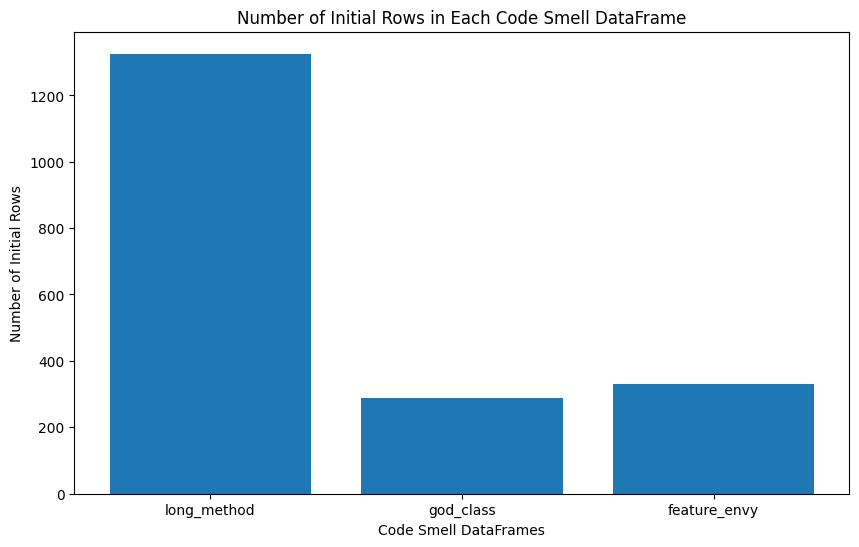

In [4]:
# Creating a bar plot to display the number of rows in each DataFrame.

import matplotlib.pyplot as plt

# Assuming you have the code_smells_df_map dictionary as defined in your previous code

df_sizes = {key: df.shape[0] for key, df in RAW_DATA_MAP.items()}

plt.figure(figsize=(10, 6))
plt.bar(df_sizes.keys(), df_sizes.values())
plt.xlabel("Code Smell DataFrames")
plt.ylabel("Number of Initial Rows")
plt.title("Number of Initial Rows in Each Code Smell DataFrame")
plt.show()

## Database's Raw Data

In [5]:
RAW_DATA_MAP[LONG_METHOD_KEY]

,username,project,package,complextype,method,NOP_method,CC_method,ATFD_method,FDP_method,CM_method,...,number_not_final_not_static_methods,number_standard_design_methods,number_constructor_DefaultConstructor_methods,number_constructor_NotDefaultConstructor_methods,num_final_static_attributes,num_not_final_not_static_attributes,num_final_not_static_attributes,num_static_not_final_attributes,isStatic_method,is_long_method
0,2020_Team1,jasml-0.10,com.jasml.compiler,com.jasml.compiler.SourceCodeParser,"private void updateLabelLinks(Hashtable#RAW, A...",2,0,25,2,0,...,23,27,0,2,0,4,0,0,0,True
1,2020_Team1,jasml-0.10,com.jasml.compiler,com.jasml.compiler.SourceCodeParser,private void preprocessConstantValues() throws...,0,0,0,0,0,...,23,27,0,2,0,4,0,0,0,False
2,2020_Team1,jasml-0.10,com.jasml.compiler,com.jasml.compiler.SourceCodeParser,private void parseClassAttributes() throws com...,0,0,3,2,0,...,23,27,0,2,0,4,0,0,0,False
3,2020_Team1,jasml-0.10,com.jasml.compiler,com.jasml.compiler.ConstantPoolGenerator,private int addMethodNameAndType(java.lang.Str...,3,0,0,0,0,...,24,23,0,1,0,6,0,0,0,False
4,2020_Team1,jasml-0.10,com.jasml.compiler,com.jasml.compiler.Scanner,private void consumeDigits(),0,0,0,0,0,...,27,20,0,4,1,22,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,2018_Team11,jfreechart-1.0.13,org.jfree.chart.annotations,org.jfree.chart.annotations.XYLineAnnotation,"public void draw(java.awt.Graphics2D, org.jfre...",7,0,2,1,0,...,8,6,0,2,1,6,0,0,0,False
1322,2018_Team11,jfreechart-1.0.13,org.jfree.chart.annotations,org.jfree.chart.annotations.CategoryLineAnnota...,"public void draw(java.awt.Graphics2D, org.jfre...",5,0,3,2,0,...,19,12,0,1,1,6,0,0,0,False
1323,2018_Team11,jfreechart-1.0.13,org.jfree.chart.annotations,org.jfree.chart.annotations.CategoryTextAnnota...,"public void draw(java.awt.Graphics2D, org.jfre...",5,0,2,1,0,...,11,7,0,1,1,3,0,0,0,False
1324,2018_Team11,jfreechart-1.0.13,org.jfree.chart.annotations,org.jfree.chart.annotations.XYDataImageAnnotation,"public void draw(java.awt.Graphics2D, org.jfre...",7,0,2,1,0,...,16,14,0,2,0,6,0,0,0,False


In [6]:
RAW_DATA_MAP[GOD_CLASS_KEY]

,username,project,package,complextype,NOII_type,NOAM_type,NOCS_type,NOM_type,NMO_type,ATFD_type,...,number_not_abstract_not_final_methods,number_static_methods,number_final_static_methods,number_final_not_static_methods,number_not_final_static_methods,number_not_final_not_static_methods,number_standard_design_methods,number_constructor_DefaultConstructor_methods,number_constructor_NotDefaultConstructor_methods,is_god_class
0,2020_Team1,jasml-0.10,com.jasml.compiler,SourceCodeParser,1,0,2,29,0,106,...,29,6,0,0,6,23,27,0,2,False
1,2020_Team1,jasml-0.10,com.jasml.helper,IntegerArray,0,1,0,3,0,0,...,3,0,0,0,0,3,1,0,1,False
2,2020_Team1,jasml-0.10,com.jasml.decompiler,JavaClassParser,0,0,0,21,0,44,...,21,1,0,0,1,20,21,0,0,False
3,2020_Team1,jasml-0.10,com.jasml.compiler,ConstantPoolGenerator,0,1,0,25,0,11,...,25,1,0,0,1,24,23,0,1,True
4,2020_Team2,jasml-0.10,com.jasml.helper,IntegerArray,0,1,0,3,0,0,...,3,0,0,0,0,3,1,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,2018_Team10,jfreechart-1.0.13,org.jfree.chart.plot,JThermometer,1,18,0,26,0,17,...,26,0,0,0,0,26,7,0,1,False
283,2018_Team10,jfreechart-1.0.13,org.jfree.chart.plot,Marker,2,12,0,35,0,0,...,35,0,0,0,0,35,20,0,3,False
284,2018_Team10,jfreechart-1.0.13,org.jfree.chart.plot,Plot,7,20,0,66,0,8,...,64,2,0,0,2,64,45,0,1,False
285,2018_Team10,jfreechart-1.0.13,org.jfree.chart.plot,MeterPlot,2,18,0,55,4,5,...,55,0,0,0,0,55,35,0,2,True


In [7]:
RAW_DATA_MAP[FEATURE_ENVY_KEY]

,username,project,package,complextype,method,NOP_method,CC_method,ATFD_method,FDP_method,CM_method,...,number_not_final_not_static_methods,number_standard_design_methods,number_constructor_DefaultConstructor_methods,number_constructor_NotDefaultConstructor_methods,num_final_static_attributes,num_not_final_not_static_attributes,num_final_not_static_attributes,num_static_not_final_attributes,isStatic_method,is_feature_envy
0,2020_Team1,jasml-0.10,com.jasml.decompiler,SourceCodeBuilder,com.jasml.decompiler.SourceCodeBuilder::toStri...,1,0,7,4,0,...,30,29,0,2,0,2,0,0,0,True
1,2020_Team1,jasml-0.10,com.jasml.compiler,JavaClassDumpper,com.jasml.compiler.JavaClassDumpper::dumpClass...,0,0,3,1,0,...,10,9,0,1,0,3,0,0,0,False
2,2020_Team1,jasml-0.10,com.jasml.compiler,JavaClassDumpper,com.jasml.compiler.JavaClassDumpper::dumpClass...,0,0,3,1,0,...,10,9,0,1,0,3,0,0,0,False
3,2020_Team2,jasml-0.10,com.jasml.decompiler,SourceCodeBuilder,com.jasml.decompiler.SourceCodeBuilder::toStri...,1,0,7,4,0,...,30,29,0,2,0,2,0,0,0,True
4,2020_Team2,jasml-0.10,com.jasml.compiler,JavaClassDumpper,com.jasml.compiler.JavaClassDumpper::dumpClass...,0,0,3,1,0,...,10,9,0,1,0,3,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,2018_Team3,jasml-0.10,com.jasml.compiler,JavaClassDumpper,com.jasml.compiler.JavaClassDumpper::dumpClass...,0,0,3,1,0,...,10,9,0,1,0,3,0,0,0,True
326,2018_Team3,jasml-0.10,com.jasml.compiler,JavaClassDumpper,com.jasml.compiler.JavaClassDumpper::dumpClass...,0,0,3,1,0,...,10,9,0,1,0,3,0,0,0,True
327,2018_Team4,jasml-0.10,com.jasml.decompiler,SourceCodeBuilder,com.jasml.decompiler.SourceCodeBuilder::toStri...,1,0,7,4,0,...,30,29,0,2,0,2,0,0,0,False
328,2018_Team4,jasml-0.10,com.jasml.compiler,JavaClassDumpper,com.jasml.compiler.JavaClassDumpper::dumpClass...,0,0,3,1,0,...,10,9,0,1,0,3,0,0,0,False


## Features Analysis

In [8]:
# finding the features for each dataset
features_map = {}
for code_smell_name, code_smell_df in RAW_DATA_MAP.items():
  features_map[code_smell_name] = set(code_smell_df.columns.tolist()) - {TARGETS_MAP[code_smell_name]}
  print(f"Features of {code_smell_name} DataFrame: {features_map[code_smell_name]}")

Features of long_method DataFrame: {'number_not_final_static_methods', 'LOC_type', 'num_static_attributes', 'LAA_method', 'WMC_type', 'NOLV_method', 'complextype', 'WOC_type', 'username', 'NOCS_package', 'LOC_method', 'LOC_project', 'NOC_type', 'number_not_abstract_not_final_methods', 'NOPA_type', 'NOMNAMM_type', 'package', 'LOCNAMM_type', 'number_private_visibility_attributes', 'ATFD_type', 'NOA_type', 'ATFD_method', 'isStatic_type', 'CLNAMM_method', 'number_final_methods', 'number_protected_visibility_attributes', 'NOAM_type', 'CDISP_method', 'CC_method', 'NOCS_type', 'NMCS_method', 'number_constructor_DefaultConstructor_methods', 'CFNAMM_method', 'num_static_not_final_attributes', 'number_final_not_static_methods', 'num_final_attributes', 'CM_method', 'number_static_methods', 'number_not_final_not_static_methods', 'WMCNAMM_type', 'number_final_static_methods', 'NOP_method', 'NOM_project', 'project', 'number_private_visibility_methods', 'number_abstract_methods', 'NOMNAMM_project', '

In [9]:
# Showing the common features for all code smells databases.
# Assuming you have the code_smells_df_map dictionary as defined in your previous code

common_features = set.intersection(*features_map.values())

print("Common features in all code smell databases:")
common_features

Common features in all code smell databases:


{'AMWNAMM_type',
 'AMW_type',
 'ATFD_type',
 'CBO_type',
 'CFNAMM_type',
 'DIT_type',
 'FANOUT_type',
 'LCOM5_type',
 'LOCNAMM_type',
 'LOC_package',
 'LOC_project',
 'LOC_type',
 'NIM_type',
 'NMO_type',
 'NOAM_type',
 'NOA_type',
 'NOCS_package',
 'NOCS_project',
 'NOCS_type',
 'NOC_type',
 'NOII_type',
 'NOI_package',
 'NOI_project',
 'NOMNAMM_package',
 'NOMNAMM_project',
 'NOMNAMM_type',
 'NOM_package',
 'NOM_project',
 'NOM_type',
 'NOPA_type',
 'NOPK_project',
 'RFC_type',
 'TCC_type',
 'WMCNAMM_type',
 'WMC_type',
 'WOC_type',
 'complextype',
 'isStatic_type',
 'num_final_attributes',
 'num_final_not_static_attributes',
 'num_final_static_attributes',
 'num_not_final_not_static_attributes',
 'num_static_attributes',
 'num_static_not_final_attributes',
 'number_abstract_methods',
 'number_constructor_DefaultConstructor_methods',
 'number_constructor_NotDefaultConstructor_methods',
 'number_final_methods',
 'number_final_not_static_methods',
 'number_final_static_methods',
 'numb

In [10]:
specific_features_map = {}

# Showing the specific features for each code smell database that are not present in "common_features"
for code_smell_name, features in features_map.items():
  specific_features = features - common_features
  # updating the specific features set on the map
  specific_features_map[code_smell_name] = specific_features
  print(f"Specific features of {code_smell_name} DataFrame: {specific_features}")

Specific features of long_method DataFrame: {'CM_method', 'LAA_method', 'NOLV_method', 'NOP_method', 'LOC_method', 'NOAV_method', 'CYCLO_method', 'MaMCL_method', 'ATFD_method', 'CLNAMM_method', 'MeMCL_method', 'ATLD_method', 'FDP_method', 'CINT_method', 'FANOUT_method', 'CDISP_method', 'isStatic_method', 'CC_method', 'NMCS_method', 'CFNAMM_method', 'MAXNESTING_method', 'method'}
Specific features of god_class DataFrame: set()
Specific features of feature_envy DataFrame: {'CM_method', 'LAA_method', 'NOLV_method', 'NOP_method', 'LOC_method', 'NOAV_method', 'CYCLO_method', 'MaMCL_method', 'ATFD_method', 'CLNAMM_method', 'MeMCL_method', 'ATLD_method', 'FDP_method', 'CINT_method', 'FANOUT_method', 'CDISP_method', 'isStatic_method', 'CC_method', 'NMCS_method', 'CFNAMM_method', 'MAXNESTING_method', 'method'}


## Removing 'username' col

In [11]:
def test_if_data_already_prepared(df_map=GROUND_TRUTH_DATA_MAP):
  """Tests if the data is already prepared."""
  already_prepared = True
  for code_smell_name, df in df_map.items():
    already_prepared = already_prepared and "package" not in df.columns
    # when the target col already present in the all dataframes,
    # we already processed all data
  return already_prepared

def run_only_if_data_not_prepared(func):
  """Runs the function only if the data is not prepared."""
  @wraps(func)
  def wrapper(*args, **kwargs):
    if not test_if_data_already_prepared():
      return func(*args, **kwargs)
    # else
    print("Data already prepared. Skipping function execution.")
    return None
  return wrapper

@run_only_if_data_not_prepared
@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def removing_useless_column_from_ground_truth_data(col_name:str):
  """
  Utility function to remove useless columns from the final dataframes.
  """
  for code_smell_name, code_smell_df in GROUND_TRUTH_DATA_MAP.items():
    if col_name in code_smell_df.columns:
      GROUND_TRUTH_DATA_MAP[code_smell_name] = code_smell_df.drop(col_name, axis=1)
      print(f"'{col_name}' column REMOVED from {code_smell_name} DataFrame.")
    else:
      print(f"Column '{col_name}' already removed from {code_smell_name} DataFrame.")

# Removing useless column: 'username'
# Assuming you have the code_smells_df_map dictionary as defined in your previous code
removing_useless_column_from_ground_truth_data('username')

Data already prepared. Skipping function execution.


In [12]:
show_current_dimensions()

Current shape of feature_envy DataFrame: (28, 91) [Raw data shape: (330, 88)]
Current shape of god_class DataFrame: (9, 68) [Raw data shape: (287, 66)]
Current shape of long_method DataFrame: (44, 91) [Raw data shape: (1326, 88)]


## Cleanning Project Feature's Data

We will delete all data related to projects other than "jasml-0.10" and remove the "project" column itself.

In [13]:
# showing all possible values for the project column in each dataframe in FINAL_DATA_MAP
for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
  if 'project' in df.columns:
    print(f"Possible values for 'project' in {code_smell_name}:")
    print(df['project'].unique())
  else:
    print(f"Column 'project' already removed from {code_smell_name} DataFrame.")


Column 'project' already removed from feature_envy DataFrame.
Column 'project' already removed from god_class DataFrame.
Column 'project' already removed from long_method DataFrame.


In [14]:
import matplotlib.pyplot as plt

@run_only_if_data_not_prepared
def plot_project_counts(final_data_map):
  """
  Generates a grouped bar plot showing the count of unique projects in each DataFrame.

  Args:
      final_data_map: A dictionary where keys are DataFrame names and values are pandas DataFrames.
  """

  project_counts = {}
  for df_name, df in final_data_map.items():
    project_counts[df_name] = df.groupby('project')['project'].count()

  # Create the bar plot
  fig, ax = plt.subplots(figsize=(12, 6))
  width = 0.2  # Width of each bar
  x = range(len(final_data_map))

  for i, project in enumerate(project_counts[list(project_counts.keys())[0]].index):
    counts = [project_counts[df_name].get(project, 0) for df_name in project_counts]
    ax.bar([xi + i * width for xi in x], counts, width=width, label=project)

  ax.set_xlabel("DataFrame")
  ax.set_ylabel("Project Count")
  ax.set_title("Count of Unique Projects in Each DataFrame")
  ax.set_xticks([xi + len(project_counts[list(project_counts.keys())[0]]) * width / 2 for xi in x])
  ax.set_xticklabels(list(project_counts.keys()))
  ax.legend()
  plt.show()


plot_project_counts(GROUND_TRUTH_DATA_MAP)


Data already prepared. Skipping function execution.


In [15]:
# Remove all data from each dataset except for those associated with the project "jasml-010."

@run_only_if_data_not_prepared
@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def remove_rows_except_jasml010(df_map=GROUND_TRUTH_DATA_MAP):
  """Removes all rows from each DataFrame except those associated with 'jasml-010' project."""
  for code_smell_name, df in df_map.items():
    # Check if the 'project' column exists in the DataFrame
    if 'project' not in df.columns:
      print(f"* Column 'project' not found in {code_smell_name} DataFrame.")
      continue
    # Remove the rows
    df_map[code_smell_name] = df[df['project'] == 'jasml-0.10']
    # Remove the 'project' column after filtering.
    df_map[code_smell_name] = df_map[code_smell_name].drop('project', axis=1)
    print(f"* Removed rows and cols except for project 'jasml-010' from {code_smell_name}.")

remove_rows_except_jasml010()

Data already prepared. Skipping function execution.


In [16]:
show_current_dimensions()

Current shape of feature_envy DataFrame: (28, 91) [Raw data shape: (330, 88)]
Current shape of god_class DataFrame: (9, 68) [Raw data shape: (287, 66)]
Current shape of long_method DataFrame: (44, 91) [Raw data shape: (1326, 88)]


##Normalizing 'complextype' col

In [17]:
@run_only_if_data_not_prepared
@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def normalize_complextype():
  """Normalizes the 'complextype' column in each DataFrame."""
  for df_name, df in GROUND_TRUTH_DATA_MAP.items():
    print(f"*** Normalizing 'complextype' column for {df_name}.")
    number_of_corrections = 0
    for index, row in df.iterrows():
      # normalizing the 'complextype', adding the 'package' value if there is no '.' in the 'complextype' value
      if '.' not in row['complextype']:
        df.at[index, 'complextype'] = row['package'] + '.' + row['complextype']
        number_of_corrections += 1
    print(f"{number_of_corrections} rows were corrected.")


normalize_complextype()

Data already prepared. Skipping function execution.


## Transforming the Target

In [18]:
@run_only_if_data_not_prepared
@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def transform_target_to_int(df_map, target_col_map):
  """Transforms the target column values from bool to int (True=1, False=-1)."""
  for df_name, df in df_map.items():
    if df_name in target_col_map:
      target_col = target_col_map[df_name]
      if target_col in df.columns:
        df[target_col] = df[target_col].map({True: 1, False: -1})
        df_map[df_name] = df
        print(f"Transformed target column '{target_col}' in '{df_name}' DataFrame to int.")
      else:
        print(f"Target column '{target_col}' not found in '{df_name}' DataFrame.")

transform_target_to_int(GROUND_TRUTH_DATA_MAP, TARGETS_MAP)

Data already prepared. Skipping function execution.


In [19]:
# Show the unique values for the target column in each DataFrame
for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
  target_col = TARGETS_MAP[code_smell_name]
  if target_col in df.columns:
    unique_target_values = df[target_col].unique()
    print(f"Unique values for target column '{target_col}' in {code_smell_name}: {unique_target_values}")
  else:
    print(f"Target column '{target_col}' not found in {code_smell_name} DataFrame.")

Unique values for target column 'is_feature_envy' in feature_envy: [ True False]
Unique values for target column 'is_god_class' in god_class: [False  True]
Unique values for target column 'is_long_method' in long_method: [False  True]


In [20]:
show_current_dimensions()

Current shape of feature_envy DataFrame: (28, 91) [Raw data shape: (330, 88)]
Current shape of god_class DataFrame: (9, 68) [Raw data shape: (287, 66)]
Current shape of long_method DataFrame: (44, 91) [Raw data shape: (1326, 88)]


## Grouping DFs (first round)

In [21]:
@run_only_if_data_not_prepared
def group_and_aggregate(df, target_col_name, basic_aggregations: dict):
    """Groups the DataFrame by specified columns and aggregates relevant columns."""

    groupby_cols=['package', 'complextype', 'method']

    # removing the groupby_cols not present on the dataset
    for col in groupby_cols:
      if col not in df.columns:
        groupby_cols.remove(col)

    # Get all columns except the grouping and target columns
    other_cols = [col for col in df.columns
                  if col not in groupby_cols + [target_col_name]]

    # Create aggregation dictionary
    aggregations = {
        **{col: 'last' for col in other_cols}  # Use 'last' for other columns
    }

    # add the basic_aggregations to the aggregations dict
    aggregations.update(basic_aggregations)

    # Group and aggregate
    try:
      grouped_df = df.groupby(groupby_cols).agg(aggregations)
    except:
      print(f"* Error grouping and aggregating (round 1). Probably it's alredy grouped.")
      return df # returning the df as was

    # Flatten multi-level column names
    grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]

    grouped_df = grouped_df.reset_index()
    return grouped_df


@run_only_if_data_not_prepared
@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def grouping_dfs_first_round():
  """Groups the DataFrames and aggregates relevant columns."""
  for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
      target_col_name = TARGETS_MAP[code_smell_name]
      basic_agg = {
          target_col_name: ['count', 'sum', ('count_negative', lambda x: (x < 0).sum()), ('count_positive', lambda x: (x > 0).sum())]
      }
      grouped_df = group_and_aggregate(df, target_col_name, basic_agg)
      GROUND_TRUTH_DATA_MAP[code_smell_name] = grouped_df
      print(f"Grouped and aggregated {code_smell_name} DataFrame.")

grouping_dfs_first_round()
show_current_dimensions()

Data already prepared. Skipping function execution.
Current shape of feature_envy DataFrame: (28, 91) [Raw data shape: (330, 88)]
Current shape of god_class DataFrame: (9, 68) [Raw data shape: (287, 66)]
Current shape of long_method DataFrame: (44, 91) [Raw data shape: (1326, 88)]


In [22]:
GROUND_TRUTH_DATA_MAP[GOD_CLASS_KEY].columns

Index(['complextype', 'NOII_type', 'NOAM_type', 'NOCS_type', 'NOM_type',
       'NMO_type', 'ATFD_type', 'FANOUT_type', 'NOMNAMM_type', 'NOA_type',
       'NIM_type', 'DIT_type', 'LOC_type', 'LOCNAMM_type', 'CFNAMM_type',
       'TCC_type', 'CBO_type', 'RFC_type', 'NOC_type', 'WMC_type',
       'LCOM5_type', 'WOC_type', 'WMCNAMM_type', 'AMW_type', 'AMWNAMM_type',
       'NOCS_package', 'NOMNAMM_package', 'NOI_package', 'LOC_package',
       'NOM_package', 'NOPK_project', 'NOCS_project', 'NOI_project',
       'NOM_project', 'NOMNAMM_project', 'LOC_project', 'isStatic_type',
       'NOPA_type', 'number_private_visibility_attributes',
       'number_protected_visibility_attributes',
       'number_package_visibility_attributes', 'num_final_attributes',
       'num_static_attributes', 'num_final_static_attributes',
       'num_not_final_not_static_attributes',
       'num_final_not_static_attributes', 'num_static_not_final_attributes',
       'number_public_visibility_methods', 'number_pri

In [23]:
# prompt: removing from the columns names the "_last" on the end

@run_only_if_data_not_prepared
def _do_remove_last_from_column_names(df):
  """Removes '_last' suffix from column names in a pandas DataFrame."""
  new_columns = [col.replace('_last', '') for col in df.columns]
  df.columns = new_columns
  return df

@run_only_if_data_not_prepared
@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def removing_lsts_from_column_names():
  """Removes '_last' suffix from column names in each DataFrame in GROUND_TRUTH_DATA_MAP."""
  for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
    GROUND_TRUTH_DATA_MAP[code_smell_name] = _do_remove_last_from_column_names(df)
    print(f"Removed '_last' from column names in {code_smell_name} DataFrame.")

removing_lsts_from_column_names()

Data already prepared. Skipping function execution.


In [24]:
GROUND_TRUTH_DATA_MAP[GOD_CLASS_KEY].columns

Index(['complextype', 'NOII_type', 'NOAM_type', 'NOCS_type', 'NOM_type',
       'NMO_type', 'ATFD_type', 'FANOUT_type', 'NOMNAMM_type', 'NOA_type',
       'NIM_type', 'DIT_type', 'LOC_type', 'LOCNAMM_type', 'CFNAMM_type',
       'TCC_type', 'CBO_type', 'RFC_type', 'NOC_type', 'WMC_type',
       'LCOM5_type', 'WOC_type', 'WMCNAMM_type', 'AMW_type', 'AMWNAMM_type',
       'NOCS_package', 'NOMNAMM_package', 'NOI_package', 'LOC_package',
       'NOM_package', 'NOPK_project', 'NOCS_project', 'NOI_project',
       'NOM_project', 'NOMNAMM_project', 'LOC_project', 'isStatic_type',
       'NOPA_type', 'number_private_visibility_attributes',
       'number_protected_visibility_attributes',
       'number_package_visibility_attributes', 'num_final_attributes',
       'num_static_attributes', 'num_final_static_attributes',
       'num_not_final_not_static_attributes',
       'num_final_not_static_attributes', 'num_static_not_final_attributes',
       'number_public_visibility_methods', 'number_pri

In [25]:
GROUND_TRUTH_DATA_MAP[FEATURE_ENVY_KEY].columns

Index(['complextype', 'method', 'NOP_method', 'CC_method', 'ATFD_method',
       'FDP_method', 'CM_method', 'MAXNESTING_method', 'LOC_method',
       'CYCLO_method', 'NMCS_method', 'NOLV_method', 'MaMCL_method',
       'NOAV_method', 'LAA_method', 'FANOUT_method', 'CFNAMM_method',
       'ATLD_method', 'CLNAMM_method', 'CINT_method', 'MeMCL_method',
       'CDISP_method', 'NOII_type', 'NOAM_type', 'NOCS_type', 'NOM_type',
       'NMO_type', 'ATFD_type', 'FANOUT_type', 'NOMNAMM_type', 'NOA_type',
       'NIM_type', 'DIT_type', 'LOC_type', 'LOCNAMM_type', 'CFNAMM_type',
       'TCC_type', 'NOPA_type', 'CBO_type', 'RFC_type', 'NOC_type', 'WMC_type',
       'LCOM5_type', 'WOC_type', 'WMCNAMM_type', 'AMW_type', 'AMWNAMM_type',
       'NOCS_package', 'NOMNAMM_package', 'NOI_package', 'LOC_package',
       'NOM_package', 'NOPK_project', 'NOCS_project', 'NOI_project',
       'NOM_project', 'NOMNAMM_project', 'LOC_project', 'isStatic_type',
       'number_private_visibility_attributes',
       

## Loading the class source

In [26]:
import requests
import zipfile
import os
import tempfile
import re
from io import BytesIO


def create_temp_dir_and_map_java_files(url):
    # Step 1: Download the ZIP file from the given URL
    response = requests.get(url)
    response.raise_for_status()

    # Step 2: Create a temporary directory to unzip the file
    with tempfile.TemporaryDirectory() as temp_dir:
        # Step 3: Unzip the file
        with zipfile.ZipFile(BytesIO(response.content)) as zip_file:
            zip_file.extractall(temp_dir)

        # Step 4: Walk through the unzipped directory to find all Java source files
        java_files = []
        for root, _, files in os.walk(temp_dir):
            for file in files:
                if file.endswith(".java"):
                    java_files.append(os.path.join(root, file))

        # Step 5: Create a map where the key is the full class name and the value is the Java source code
        java_files_map = {}
        package_pattern = re.compile(r'package\s+([\w\.]+);')
        class_pattern = re.compile(r'public\s+(class|interface|enum)\s+(\w+)')

        for java_file in java_files:
            with open(java_file, 'r', encoding='utf-8') as file:
                content = file.read()

                # Extract package name
                package_match = package_pattern.search(content)
                package_name = package_match.group(1) if package_match else ""

                # Extract class name
                class_match = class_pattern.search(content)
                class_name = class_match.group(2) if class_match else None

                if class_name:
                    # Construct the full class name
                    full_class_name = f"{package_name}.{class_name}" if package_name else class_name

                    # Add the full class name and content to the map
                    java_files_map[full_class_name] = content

        return java_files_map


JAVA_FILES_MAP = {}

@run_only_if_data_not_prepared
def load_java_files_map():
  jasml_project_url = 'https://drive.google.com/uc?id=1-D7de0s38uMXm2ysQz8GAAgNPJJ0KZGA&export=download'
  JAVA_FILES_MAP.update(create_temp_dir_and_map_java_files(jasml_project_url))
  print("Total of classes:", len(JAVA_FILES_MAP))
  # print all classes names in lexicographical order
  for class_name in sorted(JAVA_FILES_MAP.keys()):
    print(class_name)

load_java_files_map()

Data already prepared. Skipping function execution.


In [27]:
# Assuming you have the java_files_map dictionary and GROUND_TRUTH_DATA_MAP as defined in your previous code
@run_only_if_data_not_prepared
@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def add_class_source_code_column():
  """Adds a column to each DataFrame in GROUND_TRUTH_DATA_MAP with the source code of the correspondent 'complextype'."""
  for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
      df['class_source_code'] = df['complextype'].map(JAVA_FILES_MAP)
      print(f"Added 'class_source_code' column to {code_smell_name} DataFrame.")

add_class_source_code_column()

Data already prepared. Skipping function execution.


In [28]:
def show_none_values_percentage(df_map):
  """Shows the percentage of None values in the 'class_source_code' column for each DataFrame."""
  for code_smell_name, df in df_map.items():
    percentage_none = df['class_source_code'].isnull().mean() * 100
    print(f"Percentage of None values in 'class_source_code' for {code_smell_name}: {percentage_none:.2f}%")

show_none_values_percentage(GROUND_TRUTH_DATA_MAP)

Percentage of None values in 'class_source_code' for feature_envy: 0.00%
Percentage of None values in 'class_source_code' for god_class: 0.00%
Percentage of None values in 'class_source_code' for long_method: 0.00%


In [29]:
for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
  rows_with_none = df[df['class_source_code'].isnull()]
  print(f"Rows with None values for 'class_source_code' in {code_smell_name}:")
rows_with_none

Rows with None values for 'class_source_code' in feature_envy:
Rows with None values for 'class_source_code' in god_class:
Rows with None values for 'class_source_code' in long_method:


,complextype,method,NOP_method,CC_method,ATFD_method,FDP_method,CM_method,MAXNESTING_method,LOC_method,CYCLO_method,...,num_final_not_static_attributes,num_static_not_final_attributes,isStatic_method,is_long_method_count,is_long_method_sum,is_long_method_count_negative,is_long_method_count_positive,class_source_code,method_source,is_long_method


## Removing non-existent classes
As the "com.jasml.decompiler.AttributeCode" class doesn't exists on the source code, we can delete it from the correspondent data frame.

In [30]:
@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def remove_none_values():
  """Removes rows with None values in the 'class_source_code' column."""
  for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
    GROUND_TRUTH_DATA_MAP[code_smell_name] = df.dropna(subset=['class_source_code'])
    print(f"Removed rows with None values for 'class_source_code' in {code_smell_name} DataFrame.")

remove_none_values()

show_none_values_percentage(GROUND_TRUTH_DATA_MAP)

show_current_dimensions()

Loaded DataFrame 'feature_envy' from 'ground_truth_data/feature_envy.csv'.
Loaded DataFrame 'god_class' from 'ground_truth_data/god_class.csv'.
Loaded DataFrame 'long_method' from 'ground_truth_data/long_method.csv'.
Removed rows with None values for 'class_source_code' in feature_envy DataFrame.
Removed rows with None values for 'class_source_code' in god_class DataFrame.
Removed rows with None values for 'class_source_code' in long_method DataFrame.
DataFrame 'feature_envy' saved to 'ground_truth_data/feature_envy.csv'.
DataFrame 'god_class' saved to 'ground_truth_data/god_class.csv'.
DataFrame 'long_method' saved to 'ground_truth_data/long_method.csv'.
Percentage of None values in 'class_source_code' for feature_envy: 0.00%
Percentage of None values in 'class_source_code' for god_class: 0.00%
Percentage of None values in 'class_source_code' for long_method: 0.00%
Current shape of feature_envy DataFrame: (28, 91) [Raw data shape: (330, 88)]
Current shape of god_class DataFrame: (9, 6

## Fixing method names inconsistencies
There are some inconsistencies in the dataframes that relies on the method field (long_method and feature_envy).

Observe, for example, the duplicates in "com.jasml.compiler.Scanner" class.

It's necessary fix them.

In [31]:
# For each DataFrame, display the unique values for the "method" feature in lexicographic order, provided that the column is present.

@run_only_if_data_not_prepared
def show_unique_values_for_method():
  """Shows the unique values for the 'method' column in each DataFrame."""
  for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
    if 'complextype' in df.columns and 'method' in df.columns:
      print("-" * 20)
      print(f"*** Unique values for 'complextype' and 'method' in {code_smell_name}:")
      print("-" * 20)
      # Sort and select unique combinations
      unique_combinations = df[['complextype', 'method']].drop_duplicates().sort_values(by=['complextype', 'method'])
      # Format and display the unique combinations
      for index, row in unique_combinations.iterrows():
        print(f"{row['complextype']}/{row['method']}")

show_unique_values_for_method()

Data already prepared. Skipping function execution.


We are utilizing large language models (LLMs) to identify each method within every class, thereby eliminating inconsistencies.

In [32]:
def generate_extract_method_body_prompt(class_body: str, method_signature: str) -> str:
  return f"""
    You are a Java specialist programmer.
    Based on the Java class below, provide the exact original method signature and body for the method '{method_signature}'.
    //    Java class source code:  BEGIN
    {class_body}
    //    Java class source code:  END
    Your response must be in the following JSON format:
    {{"signature": "exact method signature as is in the source code",
      "body": "method body including signature"
      }}
    The "body" field must to include the method's signature.
    The "signature" field must match the exact method signature as is from the class source. Use the types, return and exceptions as is in the source code.
  """

def process_dataframe_methods(df, call_openai_api, generate_extract_method_body_prompt):
  """
  Processes a DataFrame to extract method bodies and signatures using the OpenAI API.

  Args:
      df: The DataFrame to process.
      call_openai_api: A function to call the OpenAI API.
      generate_extract_method_body_prompt: A function to generate the prompt for the OpenAI API.
  """
  if 'method' in df.columns:
    if 'method_signature' not in df.columns:
      df.loc[:, 'method_signature'] = None
    if 'method_source' not in df.columns:
      df.loc[:, 'method_source'] = None

    # fixing the hiperparameters to minimize the possibility of different results
    # Lower temperature for deterministic output
    TEMPERATURE = 0.3
    # Consider only the most likely outputs
    TOP_P = 0.9
    # Discourage repeating information
    FREQUENCY_PENALTY = 0.5
    # Slightly encourage introducing new topics
    PRESENCE_PENALTY = 0.2

    for index, row in df.iterrows():
      if row['class_source_code'] is not None:
        if pd.isnull(row['method_source']):
          # sanitizing the method name to make easier the LLM discovery
          sanitized_method = row['method'].replace('java.lang.String', 'String').replace('java.lang.Integer', 'Integer').replace('com.jasml.classes.', '').replace('com.jasml.compiler.', '').replace('java.io.', '')
          print(f"* Processing row {index} - {sanitized_method}")
          prompt = generate_extract_method_body_prompt(row['class_source_code'], sanitized_method)
          try:
            response_json = call_openai_api(user_msg=prompt,
                                            temperature=TEMPERATURE,
                                            top_p=TOP_P,
                                            frequency_penalty=FREQUENCY_PENALTY,
                                            presence_penalty=PRESENCE_PENALTY,
                                            )
            method_info = response_json["choices"][0]["message"]["content"]
            method_info = json.loads(method_info)
            df.loc[index, 'method_signature'] = method_info['signature']
            df.loc[index, 'method_source'] = method_info['body']
          except Exception as e:
            print(f"Error processing row {index}, skipping.")
            print(e)
            continue

  return df


def get_dfs_with_any_empty_method_body() -> list:
  """
  Returns a list of DataFrames that have at least one row with empty method body.
  """
  dfs_with_empty_method_body = []
  for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
    if 'method' in df.columns and ('method_source' not in df.columns or df['method_source'].isnull().any()):
      print(f"*** Found DataFrame '{code_smell_name}' with at least one row with empty method body.")
      dfs_with_empty_method_body.append(df)
  return dfs_with_empty_method_body

@run_only_if_data_not_prepared
@retry_until_true(max_retries=5, delay=1)
@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def fix_method_names() -> bool:
  """
  Fixes the method names in the GROUND_TRUTH_DATA_MAP.
  Returns:
    True if all method names are fixed, False otherwise.
  """
  dfs_with_any_empty_method_body = get_dfs_with_any_empty_method_body()

  if dfs_with_any_empty_method_body:
    print(f"** Fixing method names in {len(dfs_with_any_empty_method_body)} DataFrames.")
    for df in dfs_with_any_empty_method_body:
      process_dataframe_methods(df, call_openai_api, generate_extract_method_body_prompt)
  else:
    print("*** No DataFrames with at least one row with empty method body found.")

  return get_dfs_with_any_empty_method_body() == []


In [33]:
fix_method_names()

Data already prepared. Skipping function execution.


In [34]:
@run_only_if_data_not_prepared
@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def clean_method_cols():
  """Removes the 'method' column and renames 'method_signature' to 'method'."""
  for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
    if 'method' in df.columns and 'method_signature' in df.columns:
      df = df.drop('method', axis=1)
      df = df.rename(columns={'method_signature': 'method'})
      GROUND_TRUTH_DATA_MAP[code_smell_name] = df
      print(f"* Removed 'method' and renamed 'method_signature' to 'method' in {code_smell_name} DataFrame.")
    else:
      print(f"* DataFrame '{code_smell_name}' doesn't have 'method' or 'method_signature' columns.")

clean_method_cols()


Data already prepared. Skipping function execution.


In [35]:
show_unique_values_for_method()

Data already prepared. Skipping function execution.


We still have duplicated cases that need to be resolved. We are addressing them manually by updating the method signatures.

In [36]:
def update_method_field(df, method_map):
  """Updates the 'method' field in the DataFrame based on the provided map.

  Args:
    df: The DataFrame to update.
    method_map: A dictionary mapping old 'method' values to new 'method' values.
  """
  if 'method' in df.columns:
    df['method'] = df['method'].map(method_map).fillna(df['method'])
    print(f"* Updated 'method' field in the DataFrame.")
  else:
    print(f"* 'method' field not found in the DataFrame.")

# Create a mapping of old to new method values
method_map = {
    "private static void delComment(char[]) throws ParsingException": "private static void delComment(char[] cs) throws ParsingException",
    "private LabeledInstructions parseMethodInstructions(Method) throws ParsingException, GrammerException": "private LabeledInstructions parseMethodInstructions(Method method) throws ParsingException, GrammerException",
    "private void parseMethodAttributes(Method method, ArrayList attributes, SourceCodeParser.LabeledInstructions li, NAO Attribute_Code code, ArrayList codeAttributes) throws GrammerException, ParsingException": "private void parseMethodAttributes(Method method, ArrayList attributes, LabeledInstructions li, Attribute_Code code, ArrayList codeAttributes) throws GrammerException, ParsingException",
    "private Attribute_Code.Opcode[] parseOpcodes(byte[])": "private Attribute_Code.Opcode[] parseOpcodes(byte[] bytes)",
    "public Attribute_Code.Opcode[] parseOpcodes(byte[])": "private Attribute_Code.Opcode[] parseOpcodes(byte[] bytes)",
    "public void processOpcode(org.w3c.dom.Node)": "public void processOpcode(Node node)",
}


@run_only_if_data_not_prepared
@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def update_method_on_ground_truth_data():
  """Updates the 'method' field in the GROUND_TRUTH_DATA_MAP."""
  for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
    update_method_field(df, method_map)

update_method_on_ground_truth_data()


Data already prepared. Skipping function execution.


In [37]:
GROUND_TRUTH_DATA_MAP[LONG_METHOD_KEY].columns

Index(['complextype', 'method', 'NOP_method', 'CC_method', 'ATFD_method',
       'FDP_method', 'CM_method', 'MAXNESTING_method', 'LOC_method',
       'CYCLO_method', 'NMCS_method', 'NOLV_method', 'MaMCL_method',
       'NOAV_method', 'LAA_method', 'FANOUT_method', 'CFNAMM_method',
       'ATLD_method', 'CLNAMM_method', 'CINT_method', 'MeMCL_method',
       'CDISP_method', 'NOII_type', 'NOAM_type', 'NOCS_type', 'NOM_type',
       'NMO_type', 'ATFD_type', 'FANOUT_type', 'NOMNAMM_type', 'NOA_type',
       'NIM_type', 'DIT_type', 'LOC_type', 'LOCNAMM_type', 'CFNAMM_type',
       'TCC_type', 'NOPA_type', 'CBO_type', 'RFC_type', 'NOC_type', 'WMC_type',
       'LCOM5_type', 'WOC_type', 'WMCNAMM_type', 'AMW_type', 'AMWNAMM_type',
       'NOCS_package', 'NOMNAMM_package', 'NOI_package', 'LOC_package',
       'NOM_package', 'NOPK_project', 'NOCS_project', 'NOI_project',
       'NOM_project', 'NOMNAMM_project', 'LOC_project', 'isStatic_type',
       'number_private_visibility_attributes',
       

## Grouping DFs (second round)

In [38]:
@run_only_if_data_not_prepared
@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def grouping_dfs_second_round():
  """
  Groups the DataFrames in GROUND_TRUTH_DATA_MAP.
  """
  for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
    target_col_name = TARGETS_MAP[code_smell_name]
    basic_agg = {
        target_col_name + "_count": ['sum'],
        target_col_name + "_sum": ['sum'],
        target_col_name + "_count_negative": ['sum'],
        target_col_name + "_count_positive": ['sum'],
    }
    try:
      grouped_df = group_and_aggregate(df, target_col_name, basic_agg)
    except:
      print(f"* Error grouping {code_smell_name} DataFrame. Check if it's already grouped.")
      continue
    GROUND_TRUTH_DATA_MAP[code_smell_name] = grouped_df
    print(f"* Grouped and aggregated {code_smell_name} DataFrame.")

grouping_dfs_second_round()

Data already prepared. Skipping function execution.


In [39]:
show_current_dimensions()

Current shape of feature_envy DataFrame: (28, 91) [Raw data shape: (330, 88)]
Current shape of god_class DataFrame: (9, 68) [Raw data shape: (287, 66)]
Current shape of long_method DataFrame: (44, 91) [Raw data shape: (1326, 88)]


Observe again the "com.jasml.compiler.Scanner" class.


In [40]:
show_unique_values_for_method()

Data already prepared. Skipping function execution.


In [41]:
GROUND_TRUTH_DATA_MAP[LONG_METHOD_KEY].columns

Index(['complextype', 'method', 'NOP_method', 'CC_method', 'ATFD_method',
       'FDP_method', 'CM_method', 'MAXNESTING_method', 'LOC_method',
       'CYCLO_method', 'NMCS_method', 'NOLV_method', 'MaMCL_method',
       'NOAV_method', 'LAA_method', 'FANOUT_method', 'CFNAMM_method',
       'ATLD_method', 'CLNAMM_method', 'CINT_method', 'MeMCL_method',
       'CDISP_method', 'NOII_type', 'NOAM_type', 'NOCS_type', 'NOM_type',
       'NMO_type', 'ATFD_type', 'FANOUT_type', 'NOMNAMM_type', 'NOA_type',
       'NIM_type', 'DIT_type', 'LOC_type', 'LOCNAMM_type', 'CFNAMM_type',
       'TCC_type', 'NOPA_type', 'CBO_type', 'RFC_type', 'NOC_type', 'WMC_type',
       'LCOM5_type', 'WOC_type', 'WMCNAMM_type', 'AMW_type', 'AMWNAMM_type',
       'NOCS_package', 'NOMNAMM_package', 'NOI_package', 'LOC_package',
       'NOM_package', 'NOPK_project', 'NOCS_project', 'NOI_project',
       'NOM_project', 'NOMNAMM_project', 'LOC_project', 'isStatic_type',
       'number_private_visibility_attributes',
       

## Sanitizing the columns' names

In [42]:
def replace_terms_from_column_names(df, replace_map: dict):
  """Removes the suffix from column names in a pandas DataFrame."""
  for original_term, new_term in replace_map.items():
    new_columns = [col.replace(original_term, new_term) for col in df.columns]
    df.columns = new_columns
  return df

@run_only_if_data_not_prepared
@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def sanitize_column_names():
  """Sanitizes the column names in the GROUND_TRUTH_DATA_MAP."""
  for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
    replacement_map = {"_last": "", "_sum_sum": "_sum", "_count_sum": "_count", "_negative_sum": "_negative", "_positive_sum": "_positive"}
    GROUND_TRUTH_DATA_MAP[code_smell_name] = replace_terms_from_column_names(df, replacement_map)
    print(f"Sanitized column names in {code_smell_name} DataFrame.")

sanitize_column_names()

Data already prepared. Skipping function execution.


In [43]:
GROUND_TRUTH_DATA_MAP[LONG_METHOD_KEY].columns

Index(['complextype', 'method', 'NOP_method', 'CC_method', 'ATFD_method',
       'FDP_method', 'CM_method', 'MAXNESTING_method', 'LOC_method',
       'CYCLO_method', 'NMCS_method', 'NOLV_method', 'MaMCL_method',
       'NOAV_method', 'LAA_method', 'FANOUT_method', 'CFNAMM_method',
       'ATLD_method', 'CLNAMM_method', 'CINT_method', 'MeMCL_method',
       'CDISP_method', 'NOII_type', 'NOAM_type', 'NOCS_type', 'NOM_type',
       'NMO_type', 'ATFD_type', 'FANOUT_type', 'NOMNAMM_type', 'NOA_type',
       'NIM_type', 'DIT_type', 'LOC_type', 'LOCNAMM_type', 'CFNAMM_type',
       'TCC_type', 'NOPA_type', 'CBO_type', 'RFC_type', 'NOC_type', 'WMC_type',
       'LCOM5_type', 'WOC_type', 'WMCNAMM_type', 'AMW_type', 'AMWNAMM_type',
       'NOCS_package', 'NOMNAMM_package', 'NOI_package', 'LOC_package',
       'NOM_package', 'NOPK_project', 'NOCS_project', 'NOI_project',
       'NOM_project', 'NOMNAMM_project', 'LOC_project', 'isStatic_type',
       'number_private_visibility_attributes',
       

In [44]:
show_current_dimensions()

Current shape of feature_envy DataFrame: (28, 91) [Raw data shape: (330, 88)]
Current shape of god_class DataFrame: (9, 68) [Raw data shape: (287, 66)]
Current shape of long_method DataFrame: (44, 91) [Raw data shape: (1326, 88)]


In [45]:
GROUND_TRUTH_DATA_MAP[LONG_METHOD_KEY]

,complextype,method,NOP_method,CC_method,ATFD_method,FDP_method,CM_method,MAXNESTING_method,LOC_method,CYCLO_method,...,num_final_not_static_attributes,num_static_not_final_attributes,isStatic_method,is_long_method_count,is_long_method_sum,is_long_method_count_negative,is_long_method_count_positive,class_source_code,method_source,is_long_method
0,com.jasml.compiler.ConstantPoolGenerator,"private int addMethodNameAndType(String name, ...",3,0,0,0,0,2,19,2,...,0,0,0,54,-38,46,8,/*\n * Author jyang\n * Created on 2006-4-7 11...,"private int addMethodNameAndType(String name, ...",False
1,com.jasml.compiler.JavaClassDumpper,private void dumpAttribute(Attribute attribute...,1,0,43,12,0,5,96,20,...,0,0,0,49,27,11,38,/*\n * Author jyang\n * Created on 2006-4-12 1...,private void dumpAttribute(Attribute attribute...,True
2,com.jasml.compiler.JavaClassDumpper,private void dumpConstantPool() throws IOExcep...,0,0,29,15,0,2,53,13,...,0,0,0,28,22,3,25,/*\n * Author jyang\n * Created on 2006-4-12 1...,private void dumpConstantPool() throws IOExcep...,True
3,com.jasml.compiler.JavaClassDumpper,public void dump() throws IOException,0,0,0,0,0,1,11,1,...,0,0,0,16,-16,16,0,/*\n * Author jyang\n * Created on 2006-4-12 1...,public void dump() throws IOException {\n\tout...,False
4,com.jasml.compiler.Scanner,private static void delComment(char[] cs) thro...,1,0,0,0,0,4,47,18,...,0,0,1,57,25,16,41,/*\n * Author jyang\n * Created on 2006-5-8 16...,private static void delComment(char[] cs) thro...,True
5,com.jasml.compiler.Scanner,private void consumeDigits(),0,0,0,0,0,2,9,4,...,0,0,0,49,-49,49,0,/*\n * Author jyang\n * Created on 2006-5-8 16...,private void consumeDigits() {\n\tchar c;\n\td...,False
6,com.jasml.compiler.Scanner,private void skipSpaces(),0,0,0,0,0,2,10,4,...,0,0,0,48,-46,47,1,/*\n * Author jyang\n * Created on 2006-5-8 16...,private void skipSpaces() {\n\tchar c = read()...,False
7,com.jasml.compiler.Scanner,public int nextToken() throws ParsingException,0,1,0,0,15,4,264,94,...,0,0,0,2,2,0,2,/*\n * Author jyang\n * Created on 2006-5-8 16...,public int nextToken() throws ParsingException...,True
8,com.jasml.compiler.Scanner,public static void main(String[]) throws java....,1,0,0,0,0,3,16,4,...,0,0,1,38,-34,36,2,/*\n * Author jyang\n * Created on 2006-5-8 16...,public static void main(String[] s) throws Exc...,False
9,com.jasml.compiler.SourceCodeParser,private Attribute_InnerClasses parseInnerClass...,0,0,5,2,0,3,79,17,...,0,0,0,2,2,0,2,package com.jasml.compiler;\n\nimport java.io....,private Attribute_InnerClasses parseInnerClass...,True


## Add the target column

In [46]:
@run_only_if_data_not_prepared
@load_and_save_on_disk("ground_truth_data", GROUND_TRUTH_DATA_MAP)
def add_target_col():
  """
  Adds a target column to the GROUND_TRUTH_DATA_MAP.
  """
  for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
    print(f"Adding target column for {code_smell_name} DataFrame.")
    col_key = 'is_' + code_smell_name + '_sum'
    df[TARGETS_MAP[code_smell_name]] = df[col_key] > 0

add_target_col()

Data already prepared. Skipping function execution.


In [47]:
GROUND_TRUTH_DATA_MAP[LONG_METHOD_KEY].columns

Index(['complextype', 'method', 'NOP_method', 'CC_method', 'ATFD_method',
       'FDP_method', 'CM_method', 'MAXNESTING_method', 'LOC_method',
       'CYCLO_method', 'NMCS_method', 'NOLV_method', 'MaMCL_method',
       'NOAV_method', 'LAA_method', 'FANOUT_method', 'CFNAMM_method',
       'ATLD_method', 'CLNAMM_method', 'CINT_method', 'MeMCL_method',
       'CDISP_method', 'NOII_type', 'NOAM_type', 'NOCS_type', 'NOM_type',
       'NMO_type', 'ATFD_type', 'FANOUT_type', 'NOMNAMM_type', 'NOA_type',
       'NIM_type', 'DIT_type', 'LOC_type', 'LOCNAMM_type', 'CFNAMM_type',
       'TCC_type', 'NOPA_type', 'CBO_type', 'RFC_type', 'NOC_type', 'WMC_type',
       'LCOM5_type', 'WOC_type', 'WMCNAMM_type', 'AMW_type', 'AMWNAMM_type',
       'NOCS_package', 'NOMNAMM_package', 'NOI_package', 'LOC_package',
       'NOM_package', 'NOPK_project', 'NOCS_project', 'NOI_project',
       'NOM_project', 'NOMNAMM_project', 'LOC_project', 'isStatic_type',
       'number_private_visibility_attributes',
       

In [48]:
GROUND_TRUTH_DATA_MAP[LONG_METHOD_KEY][['method', 'is_long_method']]

,method,is_long_method
0,"private int addMethodNameAndType(String name, ...",False
1,private void dumpAttribute(Attribute attribute...,True
2,private void dumpConstantPool() throws IOExcep...,True
3,public void dump() throws IOException,False
4,private static void delComment(char[] cs) thro...,True
5,private void consumeDigits(),False
6,private void skipSpaces(),False
7,public int nextToken() throws ParsingException,True
8,public static void main(String[]) throws java....,False
9,private Attribute_InnerClasses parseInnerClass...,True


## Target Distribution

20
8


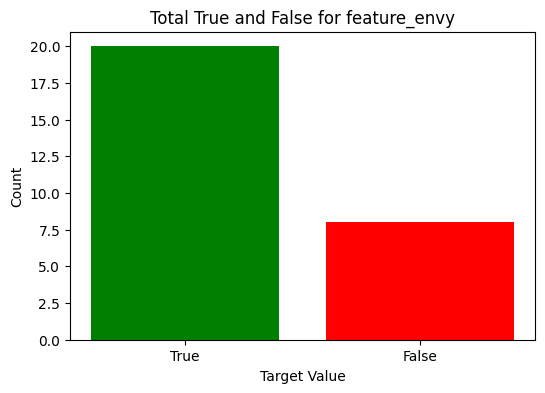



7
2


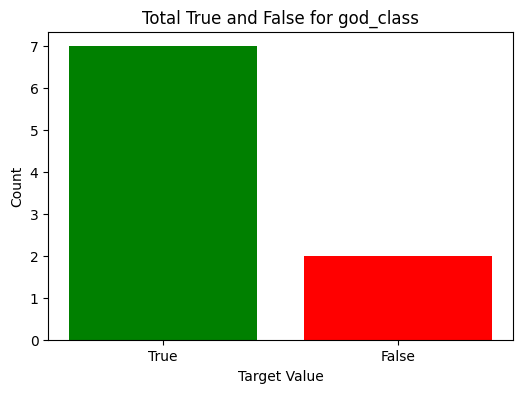



21
23


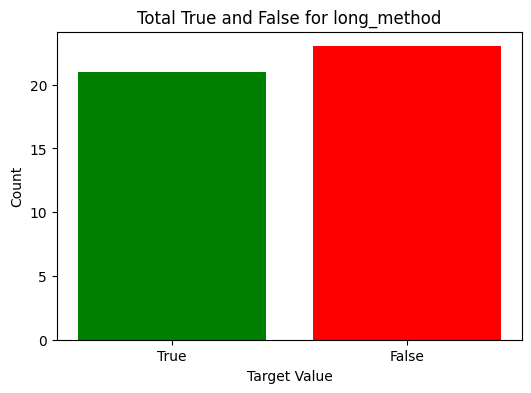

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
  if TARGETS_MAP.get(code_smell_name) in df.columns:
    target_col_name = TARGETS_MAP[code_smell_name]
    true_count = df[target_col_name].sum()
    false_count = len(df) - true_count

    print(true_count)
    print(false_count)

    plt.figure(figsize=(6, 4))
    plt.bar(['True', 'False'], [true_count, false_count], color=['green', 'red'])
    plt.title(f"Total True and False for {code_smell_name}")
    plt.xlabel("Target Value")
    plt.ylabel("Count")
    plt.show()
    print("\n")  # Add a line space between plots

## Removing 'package' column

This is the last step before processing the Research Questions.

In [50]:
removing_useless_column_from_ground_truth_data('package')

Data already prepared. Skipping function execution.


In [51]:
GROUND_TRUTH_DATA_MAP[GOD_CLASS_KEY].columns

Index(['complextype', 'NOII_type', 'NOAM_type', 'NOCS_type', 'NOM_type',
       'NMO_type', 'ATFD_type', 'FANOUT_type', 'NOMNAMM_type', 'NOA_type',
       'NIM_type', 'DIT_type', 'LOC_type', 'LOCNAMM_type', 'CFNAMM_type',
       'TCC_type', 'CBO_type', 'RFC_type', 'NOC_type', 'WMC_type',
       'LCOM5_type', 'WOC_type', 'WMCNAMM_type', 'AMW_type', 'AMWNAMM_type',
       'NOCS_package', 'NOMNAMM_package', 'NOI_package', 'LOC_package',
       'NOM_package', 'NOPK_project', 'NOCS_project', 'NOI_project',
       'NOM_project', 'NOMNAMM_project', 'LOC_project', 'isStatic_type',
       'NOPA_type', 'number_private_visibility_attributes',
       'number_protected_visibility_attributes',
       'number_package_visibility_attributes', 'num_final_attributes',
       'num_static_attributes', 'num_final_static_attributes',
       'num_not_final_not_static_attributes',
       'num_final_not_static_attributes', 'num_static_not_final_attributes',
       'number_public_visibility_methods', 'number_pri

In [52]:
show_current_dimensions()

Current shape of feature_envy DataFrame: (28, 91) [Raw data shape: (330, 88)]
Current shape of god_class DataFrame: (9, 68) [Raw data shape: (287, 66)]
Current shape of long_method DataFrame: (44, 91) [Raw data shape: (1326, 88)]


## Final State of the Data Preparation Process
The data preparation process was completed in four stages after the initial loading. Each stage refined the data, eliminating redundancies and ensuring that each observation in the final code smells data frames corresponds to a unique class or method within the analyzed system.
Below, we describe the stages and the number of rows in each data frame after each processing step for each code smell (LM: Long Method, GC: God Class, and FE: Feature Envy).


--------------------------
Stage 0: Initial loading
---------------------------
LM: 1326

GC: 287

FE: 330


--------------------------
Stage 1: Removing other projects different from 'jasml-0.10'
---------------------------
LM: 1307

GC: 276

FE: 330


--------------------------
Stage 2: Grouping by the package, complex type and method fields.
---------------------------
LM: 85

GC: 9

FE: 41


--------------------------
Stage 3: Deleting rows with null source code
---------------------------
LM: 85

GC: 9

FE: 40


--------------------------
Stage 4: Another grouping process after using LLMs support to standardize method signatures
---------------------------
LM: 43

GC: 9

FE: 28


# Research Questions
1. **RQ1**: What is the performance of an LLM in classifying code smells using only the source code and the code smell definition?

2. **RQ2**: What is the performance of an LLM in classifying code smells using metrics as part of the prompt beyond the source code and the code smell definition?

3. **RQ3**: What is the performance of an LLM in classifying code smells using custom hyperparameters beyond metrics as part of the prompt, the source code, and the code smell definition?

In [53]:
# initializing the experiment data for each code_smell
code_smells_df_map["experiments"] = {}
EXPERIMENTS_DATA_MAP = code_smells_df_map["experiments"]
EXPERIMENTS_DATA_MAP["RQ0"] = {}
RQ0_DATA_MAP = EXPERIMENTS_DATA_MAP["RQ0"]
EXPERIMENTS_DATA_MAP["RQ1"] = {}
RQ1_DATA_MAP = EXPERIMENTS_DATA_MAP["RQ1"]
EXPERIMENTS_DATA_MAP["RQ2"] = {}
RQ2_DATA_MAP = EXPERIMENTS_DATA_MAP["RQ2"]
EXPERIMENTS_DATA_MAP["RQ3"] = {}
RQ3_DATA_MAP = EXPERIMENTS_DATA_MAP["RQ3"]

for code_smell_name, df in GROUND_TRUTH_DATA_MAP.items():
  RQ0_DATA_MAP[code_smell_name] = df.copy()
  RQ1_DATA_MAP[code_smell_name] = df.copy()
  RQ2_DATA_MAP[code_smell_name] = df.copy()
  RQ3_DATA_MAP[code_smell_name] = df.copy()

code_smells_df_map["results"] = {}
RESULTS_DATA_MAP = code_smells_df_map["results"]
# for each RQ we will keep a Pandas Dataframe to persist the results
# The dataframe has as index the code_smell and as columns the basic metrics (accuracy, f1_score, and auc_score)
RESULTS_DATA_MAP["RQ0"] = pd.DataFrame(columns=["accuracy", "f1_score", "auc_score"])
RESULTS_DATA_MAP["RQ1"] = pd.DataFrame(columns=["accuracy", "f1_score", "auc_score"])
RESULTS_DATA_MAP["RQ2"] = pd.DataFrame(columns=["accuracy", "f1_score", "auc_score"])
RESULTS_DATA_MAP["RQ3"] = pd.DataFrame(columns=["accuracy", "f1_score", "auc_score"])

In [54]:
RQ0_DATA_MAP[LONG_METHOD_KEY].columns

Index(['complextype', 'method', 'NOP_method', 'CC_method', 'ATFD_method',
       'FDP_method', 'CM_method', 'MAXNESTING_method', 'LOC_method',
       'CYCLO_method', 'NMCS_method', 'NOLV_method', 'MaMCL_method',
       'NOAV_method', 'LAA_method', 'FANOUT_method', 'CFNAMM_method',
       'ATLD_method', 'CLNAMM_method', 'CINT_method', 'MeMCL_method',
       'CDISP_method', 'NOII_type', 'NOAM_type', 'NOCS_type', 'NOM_type',
       'NMO_type', 'ATFD_type', 'FANOUT_type', 'NOMNAMM_type', 'NOA_type',
       'NIM_type', 'DIT_type', 'LOC_type', 'LOCNAMM_type', 'CFNAMM_type',
       'TCC_type', 'NOPA_type', 'CBO_type', 'RFC_type', 'NOC_type', 'WMC_type',
       'LCOM5_type', 'WOC_type', 'WMCNAMM_type', 'AMW_type', 'AMWNAMM_type',
       'NOCS_package', 'NOMNAMM_package', 'NOI_package', 'LOC_package',
       'NOM_package', 'NOPK_project', 'NOCS_project', 'NOI_project',
       'NOM_project', 'NOMNAMM_project', 'LOC_project', 'isStatic_type',
       'number_private_visibility_attributes',
       

## Add LLM's cols




In [55]:
for rq_key, rq_map in EXPERIMENTS_DATA_MAP.items():
  print(f"Processing {rq_key}...")
  for code_smell_name, df in rq_map.items():
    if 'llm_user_msg' not in df.columns:
      df['llm_user_msg'] = None
      print(f"Added 'llm_user_msg' col to {code_smell_name} DataFrame.")
    if 'llm_classification' not in df.columns:
      df['llm_classification'] = None
      print(f"Added 'llm_classification' col to {code_smell_name} DataFrame.")
  print("\n")

Processing RQ0...
Added 'llm_user_msg' col to feature_envy DataFrame.
Added 'llm_classification' col to feature_envy DataFrame.
Added 'llm_user_msg' col to god_class DataFrame.
Added 'llm_classification' col to god_class DataFrame.
Added 'llm_user_msg' col to long_method DataFrame.
Added 'llm_classification' col to long_method DataFrame.


Processing RQ1...
Added 'llm_user_msg' col to feature_envy DataFrame.
Added 'llm_classification' col to feature_envy DataFrame.
Added 'llm_user_msg' col to god_class DataFrame.
Added 'llm_classification' col to god_class DataFrame.
Added 'llm_user_msg' col to long_method DataFrame.
Added 'llm_classification' col to long_method DataFrame.


Processing RQ2...
Added 'llm_user_msg' col to feature_envy DataFrame.
Added 'llm_classification' col to feature_envy DataFrame.
Added 'llm_user_msg' col to god_class DataFrame.
Added 'llm_classification' col to god_class DataFrame.
Added 'llm_user_msg' col to long_method DataFrame.
Added 'llm_classification' col to

## Utilitary functions

In [56]:
# Generic utilitary functions for the Research Questions processing

# map with the code smell definitions
CODE_SMELL_DEFINITIONS = {
    LONG_METHOD_KEY: """
    - Being excessively long.
    - Performing multiple tasks or having multiple responsibilities.
    - Having high complexity due to nested structures (loops, conditionals).
    - Being hard to understand, maintain, or extend.
    Ideally, a method should focus on a single responsibility.
    """,
    GOD_CLASS_KEY: """
    - Accumulating too many responsibilities, often having a large number of methods and attributes.
    - Managing multiple, unrelated functionalities within a single class.
    - Poor cohesion and high dependency on other classes, making it difficult to maintain and extend.
    - Violating the Single Responsibility Principle (SRP).
    Ideally, a class should focus on a single, well-defined responsibility.
    """,
    FEATURE_ENVY_KEY: """
    - A method that accesses and relies heavily on the data and functions of another class rather than its own.
    - Displaying more interest in the members of other classes, which suggests that it might be better placed in the other class.
    - Performing operations on another class’s attributes or methods, indicating a possible misplacement of the method.
    Ideally, a method should focus on the data and functions within its own class.
    """,
}

METRICS_DESCR_MAP = {
    "NOP_method": "NOP (Number of Parameters): Measures the number of parameters a method has. High NOP can indicate a complex method, often leading to difficulty in understanding and maintaining the code.",
    "CC_method": "CC (Cyclomatic Complexity): Represents the complexity of a method by counting the number of linearly independent paths. High CC suggests a method with many conditional branches, which can be error-prone and harder to test.",
    "ATFD_method": "ATFD (Access to Foreign Data): Refers to the number of accesses to attributes of other classes. A high ATFD may indicate a 'Feature Envy' smell, where a class relies heavily on data from other classes.",
    "FDP_method": "FDP (Foreign Data Providers): Counts the unique classes from which a class accesses data. High FDP suggests excessive dependence on external data, reducing encapsulation.",
    "CM_method": "CM (Coupling Metric): Measures the degree to which a class is dependent on other classes. High coupling often makes code changes more complex, as multiple classes may be affected by modifications.",
    "MAXNESTING_method": "MAXNESTING (Maximum Nesting Level): Represents the maximum depth of nested conditional or looping constructs. High MAXNESTING can make code difficult to read and debug.",
    "LOC_method": "LOC (Lines of Code): Counts the number of lines in a class or method. Higher LOC often signals complexity and can indicate the need for refactoring.",
    "CYCLO_method": "CYCLO (Cyclomatic Complexity): Another measure of complexity that counts independent paths, often used at the method level. High values can complicate testing and maintenance.",
    "NMCS_method": "NMCS (Number of Methods in a Class): Counts the methods in a class. High NMCS may indicate a 'God Class' smell, where a class has too many responsibilities.",
    "NOLV_method": "NOLV (Number of Local Variables): Counts the local variables in a method. High NOLV can make methods difficult to understand and maintain.",
    "MaMCL_method": "MaMCL (Maximum Method Complexity Level): Refers to the highest complexity level among methods in a class, often used to gauge the complexity of the most complex method.",
    "NOAV_method": "NOAV (Number of Accessed Variables): Measures the number of different variables a method accesses. A high count can indicate a method that is overly dependent on external data, reducing cohesion.",
    "LAA_method": "LAA (Locality of Attribute Accesses): Indicates how often a method accesses attributes of its own class compared to others. High LAA suggests high cohesion, while low LAA may indicate feature envy.",
    "FANOUT_method": "FANOUT (Number of Classes Called): Counts the number of classes a method or class interacts with directly. High FANOUT can lead to high coupling, which increases maintenance complexity.",
    "CFNAMM_method": "CFNAMM (Coupling Factor of Number of Accessed Methods per Method): Measures the coupling by counting the accessed methods across classes. High values suggest strong dependency on other classes, increasing coupling.",
    "ATLD_method": "ATLD (Average Token Length per Declaration): Averages the length of tokens (variable names, methods) in declarations. Short names can hinder readability, while longer names generally improve code clarity.",
    "CLNAMM_method": "CLNAMM (Class Number of Accessed Methods per Method): Measures the average number of methods a class’s methods interact with. High values may indicate that the class has multiple responsibilities, a sign of poor cohesion.",
    "CINT_method": "CINT (Coupling Intensity): Shows how much a class depends on other classes by counting the interactions. Higher values indicate high coupling, which may suggest excessive interdependencies.",
    "MeMCL_method": "MeMCL (Mean Method Complexity Level): Averages the complexity level of all methods in a class. High values may indicate that the class is complex and could benefit from refactoring.",
    "CDISP_method": "CDISP (Coupling Dispersion): Measures how interactions with other classes are distributed. A high dispersion may indicate lack of cohesion if methods are spread across unrelated classes.",
    "NOII_type": "NOII_type (Number of Incoming Invocations - type level): Counts how many times a type (class) is called by other classes, giving insight into its usage across the codebase. High values may indicate high dependency.",
    "NOAM_type": "NOAM_type (Number of Added Methods - type level): Counts the methods a class adds compared to its parent classes, helping assess the degree of customization or specialization.",
    "NOCS_type": "NOCS_type (Number of Children - type level): Counts the number of immediate subclasses. High values may suggest a broad inheritance structure, which can increase the complexity of understanding the class.",
    "NOM_type": "NOM_type (Number of Methods - type level): Counts all methods in a class, useful in assessing overall class complexity.",
    "NMO_type": "NMO (Number of Overridden Methods - type level): Counts the number of methods in a class that override methods from parent classes. A high NMO can indicate a complex inheritance structure and potential polymorphic behavior.",
    "ATFD_type": "ATFD_type (Access to Foreign Data - type level): Refers to the number of accesses to attributes of other classes. A high ATFD may indicate a 'Feature Envy' smell, where a class relies heavily on data from other classes.",
    "FANOUT_type": "FANOUT (Number of Classes Called - type level): Counts the number of classes a type interacts with directly. High FANOUT can lead to high coupling, which increases maintenance complexity.",
    "NOMNAMM_type": "NOMNAMM (Number of Methods per Number of Accessed Methods per Method - type level): A ratio that indicates how often a type's methods interact with others, useful for gauging interdependencies within a type.",
    "NOA_type": "NOA (Number of Attributes - type level): Counts the total number of attributes in a class. High NOA can indicate a complex class with many responsibilities, potentially leading to a 'God Class' smell.",
    "NIM_type": "NIM (Number of Inherited Methods - type level): Counts the methods inherited from parent classes. High NIM can indicate a deep inheritance hierarchy, which may complicate understanding and maintenance.",
    "DIT_type": "DIT_type (Depth of Inheritance Tree - type level): Measures how deep a class is in the inheritance hierarchy. High values can make it difficult to understand the class’s behavior, as it depends on multiple ancestor classes.",
    "LOC_type": "LOC_type (Lines of Code - type level): Counts the lines of code at the type level, helping assess class size and complexity, often used to gauge the overall weight of a type.",
    "LOCNAMM_type": "LOCNAMM_type (Lines of Code per Number of Accessed Methods per Method - type level): Average LOC for each accessed method, helping determine if complex methods interact heavily with others.",
    "CFNAMM_type": "CFNAMM_type (Coupling Factor of Number of Accessed Methods per Method - type level): Reflects coupling by counting accessed methods across the type. High values may indicate excessive dependency on other types.",
    "TCC_type": "TCC_type (Tight Class Cohesion - type level): Measures how closely related the methods of a class are to each other. Higher cohesion is preferable, while low TCC may suggest a lack of focus.",
    "NOPA_type": "NOPA_type (Number of Public Attributes - type level): Counts public attributes in a class, as public attributes may reduce encapsulation and lead to fragile code.",
    "CBO_type": "CBO_type (Coupling Between Objects - type level): Measures the number of classes a particular class is coupled with, with high coupling suggesting potential maintenance issues.",
    "RFC_type": "RFC_type (Response for a Class - type level): Counts the methods that can be executed in response to a message, often indicating class complexity and responsibility.",
    "NOC_type": "NOC_type (Number of Children - type level): Counts the number of immediate subclasses. High values may suggest a broad inheritance structure, which can increase the complexity of understanding the class.",
    "WMC_type": "WMC_type (Weighted Methods per Class - type level): Calculates a cumulative complexity score by adding the complexity of each method. High WMC can indicate a class with too many responsibilities.",
    "LCOM5_type": "LCOM5_type (Lack of Cohesion in Methods - type level): Measures the lack of relatedness between methods within a class. High values suggest low cohesion and may indicate a class with multiple responsibilities.",
    "WOC_type": "WOC_type (Weight of a Class - type level): Measures the functional weight of a class by examining attributes and methods, often used to gauge complexity.",
    "WMCNAMM_type": "WMCNAMM_type (Weighted Methods per Class per Number of Accessed Methods per Method): Helps measure method complexity against accessed methods, revealing coupling strength and method-to-method dependency.",
    "AMW_type": "AMW_type (Average Method Weight): Shows the average complexity of methods in a class, helping identify if methods are overly complex.",
    "AMWNAMM_type": "AMWNAMM_type (Average Method Weight per Number of Accessed Methods per Method): Similar to AMW but adjusted for accessed methods, providing insight into how complexity scales with coupling.",
    "NOCS_package": "NOCS_package (Number of Classes - package level): Counts classes within a package, used to evaluate the package’s size and cohesion.",
    "NOMNAMM_package": "NOMNAMM_package (Number of Methods per Number of Accessed Methods per Method - package level): A ratio that indicates how often package methods interact with others, useful for gauging interdependencies within a package.",
    "NOI_package": "NOI_package (Number of Interfaces - package level): Counts interfaces in a package, indicating the package’s abstraction level.",
    "LOC_package": "LOC_package (Lines of Code - package level): Counts all lines of code in a package, often used as an indicator of package size and complexity.",
    "NOMNAMM_project": "NOMNAMM_project (Number of Methods per Number of Accessed Methods per Method - project level): Shows overall coupling at the project level, helping assess dependency across the project.",
    "LOC_project": "LOC_project (Lines of Code - project level): Counts all lines of code, often used as an indicator of project size and complexity.",
    "NOM_package": "NOM_package (Number of Methods - package level): Total methods in a package, helping identify large packages that may need refactoring.",
    "NOPK_project": "NOPK_project (Number of Packages - project level): Counts packages in the project, indicating project modularity and organization.",
    "NOCS_project": "NOCS_project (Number of Classes - project level): Counts classes in the project, helping gauge project size and complexity.",
    "NOI_project": "NOI_project (Number of Interfaces - project level): Counts interfaces in the project, reflecting the project’s design abstraction level.",
    "NOM_project": "NOM_project (Number of Methods - project level): Counts all methods in the project, useful in assessing overall project complexity.",
    "NOMNAMM_project": "NOMNAMM_project (Number of Methods per Number of Accessed Methods per Method - project level): Shows overall coupling at the project level, helping assess dependency across the project.",
    "LOC_project": "LOC_project (Lines of Code - project level): Counts all lines of code, often used as an indicator of project size and complexity.",
    "LOC_package": "LOC_package (Lines of Code - package level): Measures package size by counting LOC, useful for assessing the weight of a package.",
    "isStatic_type": "isStatic_type: Indicates if the type is static. Static types often represent utility classes with globally accessible methods.",
    "number_private_visibility_attributes": "number_private_visibility_attributes: Counts private attributes in a class, reflecting encapsulation and the class's internal complexity.",
    "number_protected_visibility_attributes": "number_protected_visibility_attributes: Counts protected attributes, which can be accessed by subclasses, revealing inheritance dependency.",
    "number_package_visibility_attributes": "number_package_visibility_attributes: Counts attributes with package-private visibility, which are accessible within the same package only.",
    "num_final_attributes": "num_final_attributes: Counts final attributes, which cannot be modified after initialization, often indicating a class’s immutable aspects.",
    "num_static_attributes": "num_static_attributes: Counts static attributes, showing shared resources among instances of the class, which can lead to high coupling.",
    "number_public_visibility_methods": "number_public_visibility_methods: Counts public methods in a class, indicating how much functionality is exposed.",
    "number_private_visibility_methods": "number_private_visibility_methods: Counts private methods, showing the internal complexity of a class.",
    "number_protected_visibility_methods": "number_protected_visibility_methods: Counts protected methods, which can be accessed by subclasses.",
    "number_package_visibility_methods": "number_package_visibility_methods: Counts package-private methods, accessible only within the package.",
    "number_final_methods": "number_final_methods: Counts final methods, which cannot be overridden in subclasses, often indicating stable functionality.",
    "number_abstract_methods": "number_abstract_methods: Counts abstract methods, which must be implemented by subclasses, reflecting class abstraction.",
    "number_not_abstract_not_final_methods": "number_not_abstract_not_final_methods: Counts methods that are neither abstract nor final, indicating flexible but not mandatory customization points.",
    "number_static_methods": "number_static_methods: Counts static methods, which can be called without an instance, often indicating utility or helper methods.",
    "number_final_static_methods": "number_final_static_methods: Counts methods that are both final and static, indicating stable utility methods.",
    "number_final_not_static_methods": "number_final_not_static_methods: Counts methods that are final but not static, indicating methods that are stable yet tied to an instance.",
    "number_not_final_static_methods": "number_not_final_static_methods: Counts methods that are static but not final, indicating utility methods that can be overridden.",
    "number_not_final_not_static_methods": "number_not_final_not_static_methods: Counts methods that are neither final nor static, representing standard instance methods.",
    "number_standard_design_methods": "number_standard_design_methods: Counts methods that follow standard design patterns, indicating adherence to design principles.",
    "number_constructor_DefaultConstructor_methods": "number_constructor_DefaultConstructor_methods: Counts default constructor methods, used to initialize an object without parameters.",
    "number_constructor_NotDefaultConstructor_methods": "number_constructor_NotDefaultConstructor_methods: Counts non-default constructor methods, used to initialize an object with parameters.",
    "num_final_static_attributes": "num_final_static_attributes: Counts attributes that are both final and static, indicating constants shared across instances.",
    "num_not_final_not_static_attributes": "num_not_final_not_static_attributes: Counts attributes that are neither final nor static, representing standard instance variables.",
    "num_final_not_static_attributes": "num_final_not_static_attributes: Counts attributes that are final but not static, indicating immutable instance-level constants.",
    "num_static_not_final_attributes": "num_static_not_final_attributes: Counts attributes that are static but not final, indicating shared resources across instances.",
    "isStatic_method": "isStatic_method: Indicates if the method is static, meaning it can be called without an instance of the class."
}

def gen_rq0_context():
  """Generates a prompt for the RQ0."""
  return """The list below presents common code smells (aka bad smells). I need to check if the Java code provided at the end of the input contains at least one of them.
   * God Class
   * Feature Envy
   * Long Method
   Could you please identify which smells occur in the following code? However, do not describe the smells, just list them.
   Please start your answer with “YES I found bad smells” when you find any bad smell. Otherwise, start your answer with “NO, I did not find any bad smell”.
   When you start to list the detected bad smells, always put in your answer “the bad smells are:” amongst the text your answer and always separate it in this format: 1. Long method, 2. Feature envy ...
   """

def gen_rq1_context(code_smell_name):
  """Generates a prompt for the RQ."""
  code_smell_definition = CODE_SMELL_DEFINITIONS[code_smell_name]
  code_smell_level = "method"
  if code_smell_name == GOD_CLASS_KEY:
    code_smell_level = "class"

  return f"""
    You are an expert Java software engineer specializing in code smells, particularly the '{code_smell_name}' code smell.
    When provided with a Java {code_smell_level}, your task is to analyze it to determine if it exhibits the '{code_smell_name}' code smell.

    A '{code_smell_name}' code smell is characterized by:
    {code_smell_definition}

    **Instructions:**
    1. **Classification**: Determine if the {code_smell_level} is a case of '{code_smell_name}'. Use `'True'` if it is, otherwise `'False'`.
    2. Classify the {code_smell_level} as '{code_smell_name}' only if you are confident in your analysis. That is, be quite strict and restrictive when identifying this Code Smell.
    3. The {code_smell_level}'s body is delimited by `***SOURCE CODE: BEGIN***` and `***SOURCE CODE: END***`

    **Your response should be in the following JSON format:**
    ```json
    {{
      'classification': 'True' or 'False',
    }}
    """

def gen_rq2_context(code_smell_name):
  """Generates a prompt for RQ2."""
  code_smell_definition = CODE_SMELL_DEFINITIONS[code_smell_name]
  code_smell_level = "method"
  if code_smell_name == GOD_CLASS_KEY:
    code_smell_level = "class"
  context = f"""
    You are an expert Java software engineer specializing in code smells, particularly the '{code_smell_name}' code smell.
    When provided with metrics regarding to a Java {code_smell_level}, your task is to analyze it to determine if it exhibits the '{code_smell_name}' code smell.

    A '{code_smell_name}' code smell is characterized by:
    {code_smell_definition}

    **Instructions:**
    1. **Classification**: Determine if the {code_smell_level} is a case of '{code_smell_name}'. Use `'True'` if it is, otherwise `'False'`.
    2. Classify the {code_smell_level} as '{code_smell_name}' only if you are confident in your analysis. That is, be quite strict and restrictive when identifying this Code Smell.
    3. The {code_smell_level}'s body is delimited by `***SOURCE CODE: BEGIN***` and `***SOURCE CODE: END***`
    4. Keep in mind the objective metrics provided in your evaluation.
    5. The metrics are delimited by `***METRICS: BEGIN***` and `***METRICS: END***`


    **Your response should be in the following JSON format:**
    ```json
    {{
      'classification': 'True' or 'False',
    }}
  """
  context += "**In your response, consider the following definitions for the metrics:**\n"
  for metric, description in METRICS_DESCR_MAP.items():
    context += f" - {metric}: {description}\n"

  return context

def gen_rq3_context(code_smell_name):
  """Generates a prompt for RQ3."""
  # Exactly the same of RQ2
  return gen_rq2_context(code_smell_name)

def gen_context(rq: str, code_smell_name):
  """Generates a prompt for the given research question."""
  if rq == "RQ0":
    return gen_rq0_context()
  if rq == "RQ1":
    return gen_rq1_context(code_smell_name)
  # else
  if rq == "RQ2":
    return gen_rq2_context(code_smell_name)
  # else
  if rq == "RQ3":
    return gen_rq3_context(code_smell_name)
  else:
    raise ValueError(f"Invalid research question: {rq}")

def removing_metric_cols(rq: str):
  """Updates the columns for an RQ."""
  # updating the cols useful for the RQ
  data_map = EXPERIMENTS_DATA_MAP[rq]
  for code_smell_name, df in data_map.items():
    allowed_cols = ['complextype', 'class_source_code']
    if 'method' in df.columns:
      allowed_cols.append('method')
    if 'method_source' in df.columns:
      allowed_cols.append('method_source')

    target_col = TARGETS_MAP[code_smell_name]
    allowed_cols.append(target_col + "_count")
    allowed_cols.append(target_col + "_sum")
    allowed_cols.append(target_col + "_count_negative")
    allowed_cols.append(target_col + "_count_positive")
    allowed_cols.append(target_col)
    allowed_cols.append('llm_user_msg')
    allowed_cols.append('llm_classification')

    df = df[allowed_cols]
    data_map[code_smell_name] = df
    print(f"Filtered columns in {code_smell_name} DataFrame.")
    print(data_map[code_smell_name].columns)
    print("\n")


def rq_request_llm_classification(context: str, code_excerpt: str,
                    temperature=None, top_p=None, frequency_penalty=None,
                    presence_penalty=None, llm_response_as_json: bool = True) -> bool | str:
  """
  Requests the LLM for long method classification.
  """
  llm_full_response = call_openai_api(context=context, user_msg=code_excerpt,
                                      temperature=temperature,
                                      top_p=top_p,
                                      frequency_penalty=frequency_penalty,
                                      presence_penalty=presence_penalty,
                                      response_as_json=llm_response_as_json)
  # return only the msg as a python dict object
  llm_response_content = llm_full_response['choices'][0]['message']['content']
  if llm_response_as_json:
    llm_response_content = json.loads(llm_response_content)
    return llm_response_content['classification']
  # else:
  return llm_response_content

def get_source_code_excerpt(row, rq):
  """
  Returns the source code excerpt for the given row index.
  """
  code_excerpt = ""
  if rq != "RQ0":
    # Keeping the RQ0's prompt equal to design in the original paper.
    code_excerpt = "\n*** SOURCE CODE: BEGIN ***\n"
  if 'method_source' in row:
    code_excerpt += row['method_source']
  else:
    code_excerpt += row['class_source_code']
  if rq != "RQ0":
    # Keeping the RQ0's prompt equal to design in the original paper.
    code_excerpt += "\n*** SOURCE CODE: END ***\n"
  return code_excerpt

@retry_until_true(max_retries=5, delay=1)
def process_llm_classification(rq: str, include_metrics=False,
                    temperature=None, top_p=None, frequency_penalty=None,
                    presence_penalty=None,
                    llm_response_as_json: bool = True) -> bool:
  """
  Processes the LLM classification for the given data map.
  """
  data_map = EXPERIMENTS_DATA_MAP[rq]
  print(f"*** Processing {rq}")

  def stop_process_llm_classification_condition(data_map)->bool:
    """
    Stops the process of LLM classification for the given data map.
    """
    print("Checking stop condition...")
    nan_count = 0
    for code_smell_name, df in data_map.items():
      print(f" Checking {code_smell_name}")
      nan_count += df['llm_classification'].isna().sum()
      print(f"  {code_smell_name}: Number of NaN values in 'llm_classification': {nan_count}")
    print("\n")
    return nan_count == 0


  for code_smell_name, df in data_map.items():
    print(f" ** Processing {code_smell_name}...")
    context = gen_context(rq, code_smell_name)

    for index, row in df.iterrows():
      if not pd.isna(row['llm_user_msg']):
        # print(f"* Row {index} already processed.")
        continue

      code_excerpt = ''
      code_excerpt += get_source_code_excerpt(row, rq)

      if include_metrics:
        metrics_excerpt = "\n*** METRICS: BEGIN ***\n"
        for col in df.columns:
          if col in METRICS_DESCR_MAP:
            metrics_excerpt += f"{col} = {row[col]}\n"
          elif (code_smell_name not in col) and (col not in ['llm_user_msg', 'llm_classification', 'complextype', 'method', 'class_source_code', 'method_source']):
            raise ValueError(f"Invalid column name: {col}")

        metrics_excerpt += "\n*** METRICS: END ***\n"
        code_excerpt += metrics_excerpt

      print(f"Processing row {index}:\n{code_excerpt[:100]}")
      try:
        llm_classification = rq_request_llm_classification(context, code_excerpt,
                    temperature, top_p, frequency_penalty, presence_penalty,
                    llm_response_as_json)
        print(f"LLM classification for row {index}: {llm_classification}")
      except Exception as e:
        print(f"Error processing row {index}: {e}")
        print(row)
        print(f"Context: {context}")
        print(f"Code Excerpt: {code_excerpt}")
        raise

      df.at[index, 'llm_user_msg'] = code_excerpt
      df.at[index, 'llm_classification'] = llm_classification
      print('-'*25)
  return stop_process_llm_classification_condition(data_map)

import pandas as pd
import random

def get_random_row_llm_info(rq: str):
  """
  Gets a random row from the specified research question's data map,
  showing the 'llm_user_msg' and 'llm_classification' values.

  Args:
    rq: The research question key (e.g., "RQ1").

  Returns:
    A tuple containing the 'llm_user_msg' and 'llm_classification'
    values from a randomly selected row.
  """
  data_map = EXPERIMENTS_DATA_MAP[rq]
  code_smell_name = random.choice(list(data_map.keys()))
  df = data_map[code_smell_name]
  if not df.empty and 'llm_user_msg' in df.columns and 'llm_classification' in df.columns:
    row = df.sample(n=1)
    return code_smell_name, row['llm_user_msg'].iloc[0], row['llm_classification'].iloc[0]
  else:
    return None, None, None


def print_random_llm_info(rq: str):
  """
  Prints a random row from the specified research question's data map,
  showing the 'llm_user_msg' and 'llm_classification' values.

  Args:
    rq: The research question key (e.g., "RQ1").
  """
  code_smell_name, llm_user_msg, llm_classification = get_random_row_llm_info(rq)
  if llm_user_msg and llm_classification:
    print("Random Row:")
    print(f"Code Smell: {code_smell_name}")
    print("llm_user_msg:", llm_user_msg)
    print("llm_classification:", llm_classification)
  else:
    print("No data available for this RQ or columns not found.")


## Result Functions

In [57]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, roc_auc_score, f1_score


import matplotlib.pyplot as plt

def _metrics_2_str(y_true, y_pred):
  """
  Returns a detailed title for the confusion matrix or ROC curve plot.

  Parameters:
      y_true (pd.Series): True labels.
      y_pred (pd.Series): Predicted labels.

  Returns:
      str: Detailed title for the
  """
  # ensure y_true and y_pred are bool values
  y_true = y_true.apply(lambda x: str(x).upper() == 'TRUE')
  y_pred = y_pred.apply(lambda x: str(x).upper() == 'TRUE')

  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average='weighted')
  roc_auc = roc_auc_score(y_true, y_pred)
  return (f"Accuracy: {accuracy:.2f}, F1-Score: {f1:.2f}, ROC AUC: {roc_auc:.2f}", accuracy, f1, roc_auc)


def plot_confusion_matrix(y_true, y_pred, title):
    """
    Plots a confusion matrix for given true and predicted labels.

    Parameters:
        y_true (pd.Series): True labels.
        y_pred (pd.Series): Predicted labels.
        title (str): Title for the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

def plot_roc_curve(y_true, y_pred, title):
    """
    Plots the ROC curve for given true and predicted labels.

    Parameters:
        y_true (pd.Series): True labels.
        y_pred (pd.Series): Predicted labels.
        title (str): Title for the plot.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def evaluate_code_smell(rq, code_smell_name: str, df, target_column, y_pred_col_name='llm_classification'):
    """
    Evaluates the model's performance on a specific code smell.

    Parameters:
        rq (str): Research question identifier.
        code_smell_name (str): Name of the code smell.
        df (pd.DataFrame): DataFrame containing the data.
        target_column (str): Column name for the target labels.
    """
    y_true = df[target_column].apply(lambda x: str(x).upper() == 'TRUE')
    y_pred = df[y_pred_col_name].apply(lambda x: str(x).upper() == 'TRUE')
    # print(f"{rq} - Classification Report - {code_smell_name}")
    # print(classification_report(y_true, y_pred, zero_division=0))
    # print("\n")

    # Plot confusion matrix and ROC curve
    # formating the code_smell_name
    code_smell_name = code_smell_name.replace("_", " ").upper()
    metrics_details, accuracy, f1, roc_auc = _metrics_2_str(y_true, y_pred)
    cm_title = f'{rq} - Confusion Matrix - {code_smell_name}\n{metrics_details}'
    plot_confusion_matrix(y_true, y_pred, cm_title)
    print("\n")
    plot_roc_curve(y_true, y_pred, f'{rq} - ROC Curve - {code_smell_name}\n{metrics_details}')
    print("\n" + ("*"*25) + "\n")

    # saving the results on the RESULTS_DATA_MAP
    rq_results_df = RESULTS_DATA_MAP[rq]
    # saving the code smell detailed result as a Pandas Dataframe
    # The index is the code smell name and the col are the metrics
    rq_results_df.loc[code_smell_name] = [accuracy, f1, roc_auc]


def rq_results(rq):
    """
    Generates evaluation results for each code smell in the given research question.

    Parameters:
        rq (str): Research question identifier.
    """
    data_map = EXPERIMENTS_DATA_MAP[rq]

    all_y_together_df = pd.DataFrame()

    for code_smell_name, df in data_map.items():
        target_column = TARGETS_MAP[code_smell_name]
        evaluate_code_smell(rq, code_smell_name, df, target_column)
        # evaluate_code_smell_summary(rq, code_smell_name, df, target_column)

        # Explicitly create a copy of the df
        y_df = df.copy()

        # Renaming columns
        y_df.rename(columns={'is_' + code_smell_name: 'y_pred', 'llm_classification': 'y_true'}, inplace=True)

        # Appending all rows from y_df to all_y_together_df
        all_y_together_df = pd.concat([all_y_together_df, y_df], ignore_index=True)

    # calling evaluate_code_smell for the all_y_together_df
    evaluate_code_smell(rq, "ALL", all_y_together_df, "y_true", "y_pred")

    print('Summary')
    print(RESULTS_DATA_MAP[rq])

## RQ0
What is the performance of an LLM in classifying code smells using the prompt proposed by (SILVA et al, 2024)?

In [58]:
@load_and_save_on_disk("rq0_data", RQ0_DATA_MAP)
def rq0_update_cols():
  """Updates the columns for RQ0."""
  removing_metric_cols("RQ0")

rq0_update_cols()
show_current_dimensions(data_map=RQ0_DATA_MAP, extra_info=False)

Loaded DataFrame 'feature_envy' from 'rq0_data/feature_envy.csv'.
Loaded DataFrame 'god_class' from 'rq0_data/god_class.csv'.
Loaded DataFrame 'long_method' from 'rq0_data/long_method.csv'.
Filtered columns in feature_envy DataFrame.
Index(['complextype', 'class_source_code', 'method', 'method_source',
       'is_feature_envy_count', 'is_feature_envy_sum',
       'is_feature_envy_count_negative', 'is_feature_envy_count_positive',
       'is_feature_envy', 'llm_user_msg', 'llm_classification'],
      dtype='object')


Filtered columns in god_class DataFrame.
Index(['complextype', 'class_source_code', 'is_god_class_count',
       'is_god_class_sum', 'is_god_class_count_negative',
       'is_god_class_count_positive', 'is_god_class', 'llm_user_msg',
       'llm_classification'],
      dtype='object')


Filtered columns in long_method DataFrame.
Index(['complextype', 'class_source_code', 'method', 'method_source',
       'is_long_method_count', 'is_long_method_sum',
       'is_long_method_

In [59]:
@load_and_save_on_disk("rq0_data", RQ0_DATA_MAP)
def process_rq0_data():
  """
  Processes the RQ0 data.
  """
  return process_llm_classification("RQ0", llm_response_as_json=False)

process_rq0_data()

Loaded DataFrame 'feature_envy' from 'rq0_data/feature_envy.csv'.
Loaded DataFrame 'god_class' from 'rq0_data/god_class.csv'.
Loaded DataFrame 'long_method' from 'rq0_data/long_method.csv'.
*** Processing RQ0
 ** Processing feature_envy...
 ** Processing god_class...
 ** Processing long_method...
Checking stop condition...
 Checking feature_envy
  feature_envy: Number of NaN values in 'llm_classification': 0
 Checking god_class
  god_class: Number of NaN values in 'llm_classification': 0
 Checking long_method
  long_method: Number of NaN values in 'llm_classification': 0


Condition satisfied. Exiting retry loop.
DataFrame 'feature_envy' saved to 'rq0_data/feature_envy.csv'.
DataFrame 'god_class' saved to 'rq0_data/god_class.csv'.
DataFrame 'long_method' saved to 'rq0_data/long_method.csv'.


True

In [60]:
RQ0_DATA_MAP[LONG_METHOD_KEY]["llm_classification"].value_counts()

,count
llm_classification,
True,38
False,6


In [61]:
RQ0_DATA_MAP[GOD_CLASS_KEY]["llm_classification"].value_counts()

,count
llm_classification,
True,8
False,1


In [62]:
RQ0_DATA_MAP[FEATURE_ENVY_KEY]["llm_classification"].value_counts()

,count
llm_classification,
False,28


### Converting Raw Response

In [63]:
@load_and_save_on_disk("rq0_data", RQ0_DATA_MAP)
def _rq0_create_col_raw_llm_response():
  """
  Creates a new column 'raw_llm_response' in the RQ0 data map.
  """
  for code_smell_name, df in RQ0_DATA_MAP.items():
    if 'raw_llm_response' not in df.columns:
      df['raw_llm_response'] = df['llm_classification']

# saving the raw LLM response before convert it to boolean
_rq0_create_col_raw_llm_response()

RQ0_DATA_MAP[LONG_METHOD_KEY]["raw_llm_response"].value_counts()

Loaded DataFrame 'feature_envy' from 'rq0_data/feature_envy.csv'.
Loaded DataFrame 'god_class' from 'rq0_data/god_class.csv'.
Loaded DataFrame 'long_method' from 'rq0_data/long_method.csv'.
DataFrame 'feature_envy' saved to 'rq0_data/feature_envy.csv'.
DataFrame 'god_class' saved to 'rq0_data/god_class.csv'.
DataFrame 'long_method' saved to 'rq0_data/long_method.csv'.


,count
raw_llm_response,
True,38
False,6


In [64]:
@load_and_save_on_disk("rq0_data", RQ0_DATA_MAP)
def _rq0_convert_llm_classification_to_boolean():
    """
    Convert the `llm_classification` column in the df to boolean
    based on the presence of the string code_smell.
    """
    column_name = "llm_classification"
    for code_smell_name, df in RQ0_DATA_MAP.items():
      code_smell_name = code_smell_name.replace("_", " ").title()
      print("-"*10)
      print(f"Converting {code_smell_name}")
      # test if the df[column_name] type is str
      if df[column_name].dtype == 'object':
        df[column_name] = df[column_name].str.contains(code_smell_name, case=False, na=False)
        df[column_name] = df[column_name].astype(bool)  # Ensure column is explicitly boolean
      print(df[column_name].value_counts())
    print("-"*10)

_rq0_convert_llm_classification_to_boolean()

# Verify if changes are reflected
RQ0_DATA_MAP[LONG_METHOD_KEY]["llm_classification"].value_counts()


Loaded DataFrame 'feature_envy' from 'rq0_data/feature_envy.csv'.
Loaded DataFrame 'god_class' from 'rq0_data/god_class.csv'.
Loaded DataFrame 'long_method' from 'rq0_data/long_method.csv'.
----------
Converting Feature Envy
llm_classification
False    28
Name: count, dtype: int64
----------
Converting God Class
llm_classification
True     8
False    1
Name: count, dtype: int64
----------
Converting Long Method
llm_classification
True     38
False     6
Name: count, dtype: int64
----------
DataFrame 'feature_envy' saved to 'rq0_data/feature_envy.csv'.
DataFrame 'god_class' saved to 'rq0_data/god_class.csv'.
DataFrame 'long_method' saved to 'rq0_data/long_method.csv'.


,count
llm_classification,
True,38
False,6


### Results

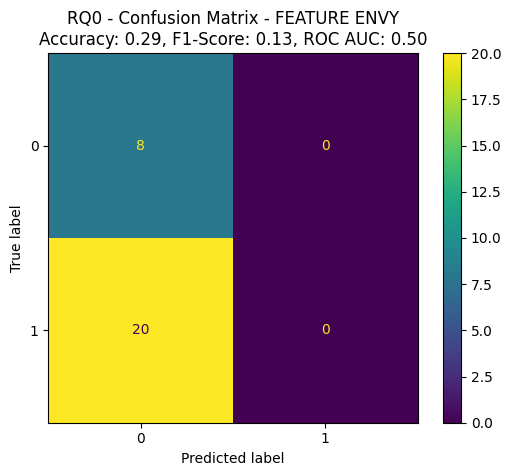

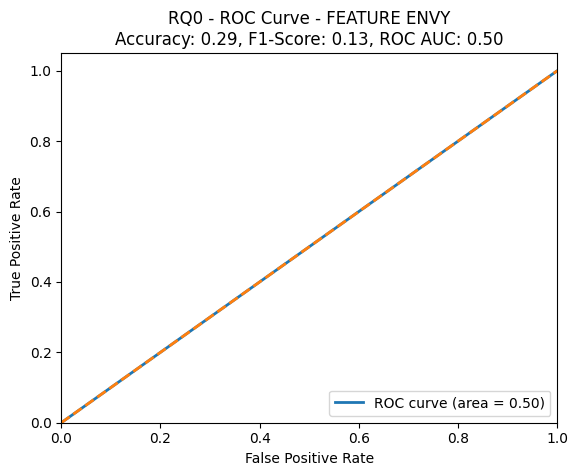


*************************



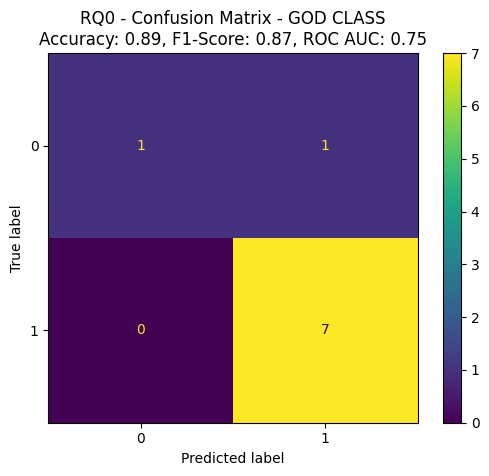

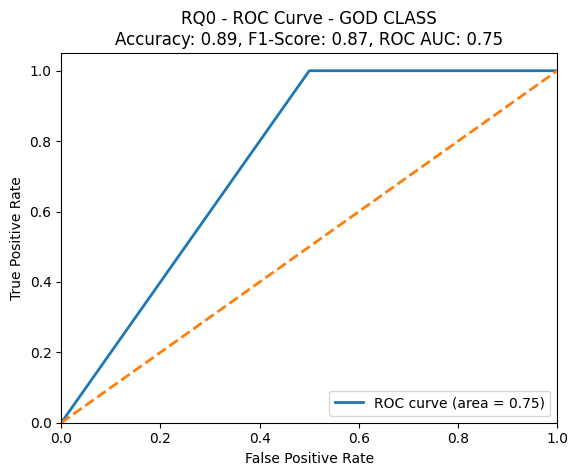


*************************



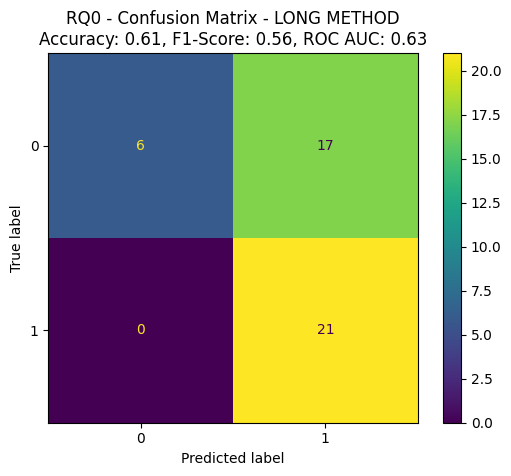

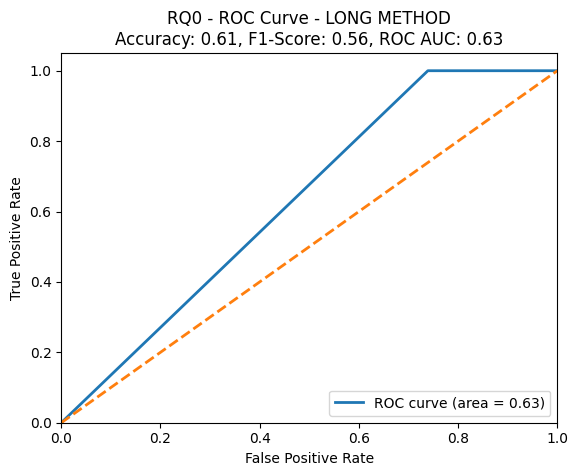


*************************



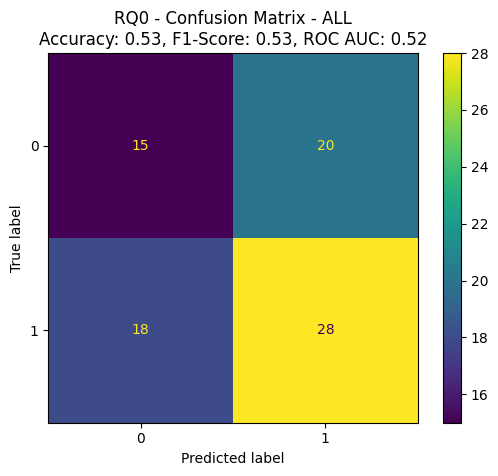

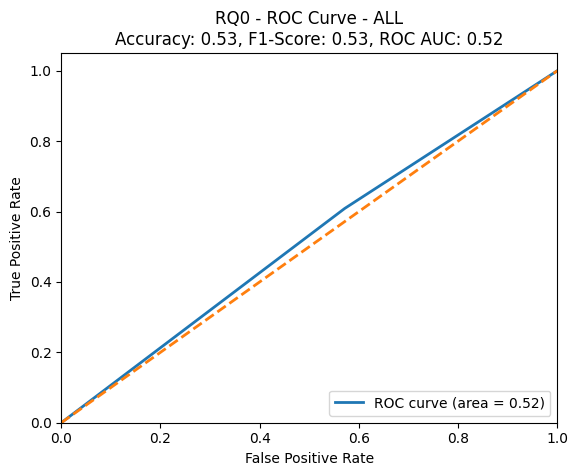


*************************

Summary
              accuracy  f1_score  auc_score
FEATURE ENVY  0.285714  0.126984   0.500000
GOD CLASS     0.888889  0.874074   0.750000
LONG METHOD   0.613636  0.556054   0.630435
ALL           0.530864  0.528956   0.518634


In [65]:
rq_results("RQ0")

## RQ1
What is the performance of an LLM in classifying code smells using only the source code and the code smell definition?

In [66]:
@load_and_save_on_disk("rq1_data", RQ1_DATA_MAP)
def rq1_update_cols():
  """Updates the columns for RQ1."""
  removing_metric_cols("RQ1")

rq1_update_cols()
show_current_dimensions(data_map=RQ1_DATA_MAP, extra_info=False)

Loaded DataFrame 'feature_envy' from 'rq1_data/feature_envy.csv'.
Loaded DataFrame 'god_class' from 'rq1_data/god_class.csv'.
Loaded DataFrame 'long_method' from 'rq1_data/long_method.csv'.
Filtered columns in feature_envy DataFrame.
Index(['complextype', 'class_source_code', 'method', 'method_source',
       'is_feature_envy_count', 'is_feature_envy_sum',
       'is_feature_envy_count_negative', 'is_feature_envy_count_positive',
       'is_feature_envy', 'llm_user_msg', 'llm_classification'],
      dtype='object')


Filtered columns in god_class DataFrame.
Index(['complextype', 'class_source_code', 'is_god_class_count',
       'is_god_class_sum', 'is_god_class_count_negative',
       'is_god_class_count_positive', 'is_god_class', 'llm_user_msg',
       'llm_classification'],
      dtype='object')


Filtered columns in long_method DataFrame.
Index(['complextype', 'class_source_code', 'method', 'method_source',
       'is_long_method_count', 'is_long_method_sum',
       'is_long_method_

In [67]:
@load_and_save_on_disk("rq1_data", RQ1_DATA_MAP)
def process_rq1_data():
  """
  Processes the RQ1 data.
  """
  return process_llm_classification("RQ1")

process_rq1_data()


Loaded DataFrame 'feature_envy' from 'rq1_data/feature_envy.csv'.
Loaded DataFrame 'god_class' from 'rq1_data/god_class.csv'.
Loaded DataFrame 'long_method' from 'rq1_data/long_method.csv'.
*** Processing RQ1
 ** Processing feature_envy...
 ** Processing god_class...
 ** Processing long_method...
Checking stop condition...
 Checking feature_envy
  feature_envy: Number of NaN values in 'llm_classification': 0
 Checking god_class
  god_class: Number of NaN values in 'llm_classification': 0
 Checking long_method
  long_method: Number of NaN values in 'llm_classification': 0


Condition satisfied. Exiting retry loop.
DataFrame 'feature_envy' saved to 'rq1_data/feature_envy.csv'.
DataFrame 'god_class' saved to 'rq1_data/god_class.csv'.
DataFrame 'long_method' saved to 'rq1_data/long_method.csv'.


True

In [68]:
print_random_llm_info("RQ1")

Random Row:
Code Smell: long_method
llm_user_msg: 
*** SOURCE CODE: BEGIN ***
private void dumpAttribute(Attribute attribute) throws IOException {
	out.writeShort(attribute.attribute_name_index);
	out.writeInt(attribute.attribute_length);

	switch (attribute.attribute_tag) {
	case Constants.ATTRIBUTE_SourceFile:
		out.writeShort(((Attribute_SourceFile) attribute).sourcefile_index);
		break;

	case Constants.ATTRIBUTE_ConstantValue:
		out.writeShort(((Attribute_ConstantValue) attribute).constant_value_index);
		break;

	case Constants.ATTRIBUTE_Code:
		Attribute_Code code = (Attribute_Code) attribute;
		byte[][] operands;

		out.writeShort(code.max_stack);
		out.writeShort(code.max_locals);
		out.writeInt(code.code_length);

		// codes
		Attribute_Code.Opcode op;
		for (int i = 0; i < code.codes.length; i++) {
		op = code.codes[i];
	.out.writeByte(op.opcode);

            operands = op.operands;
            if (operands != null && operands.length != 0) {
                for (int j = 0; 

### Results

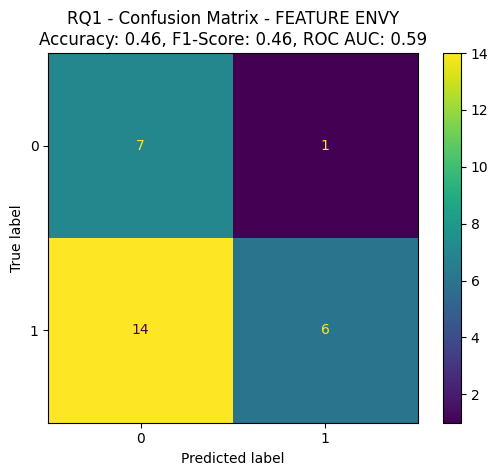

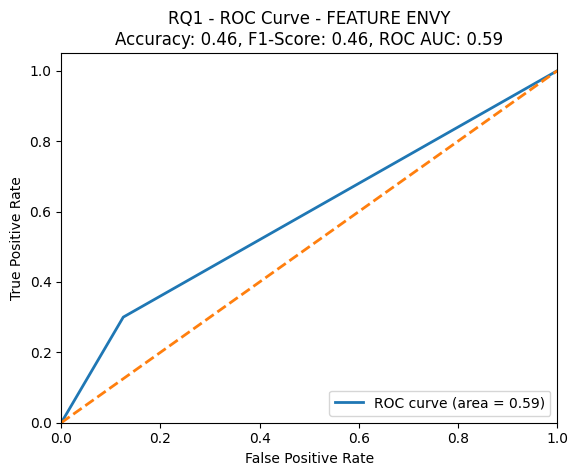


*************************



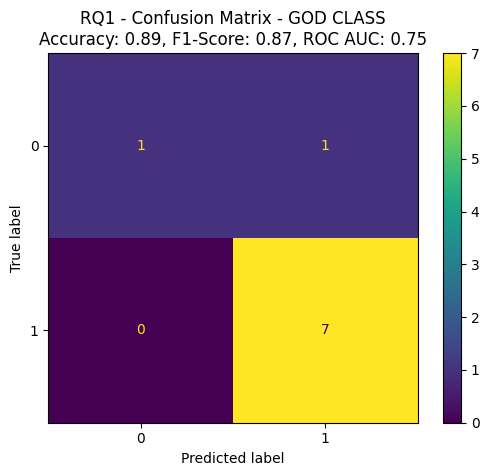

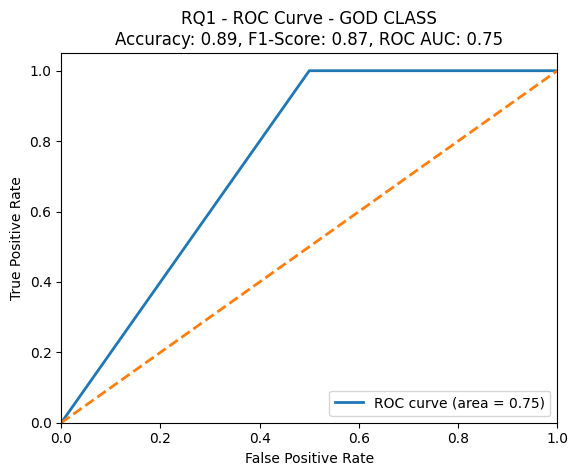


*************************



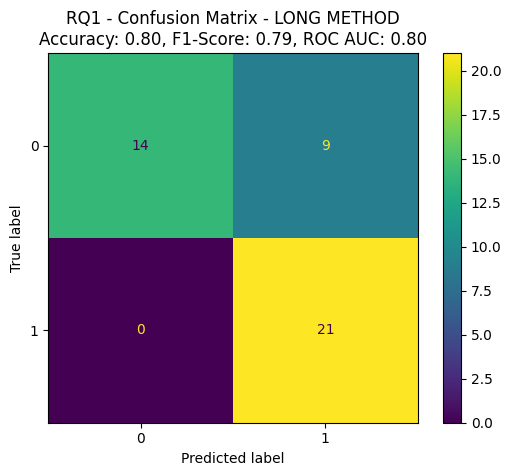

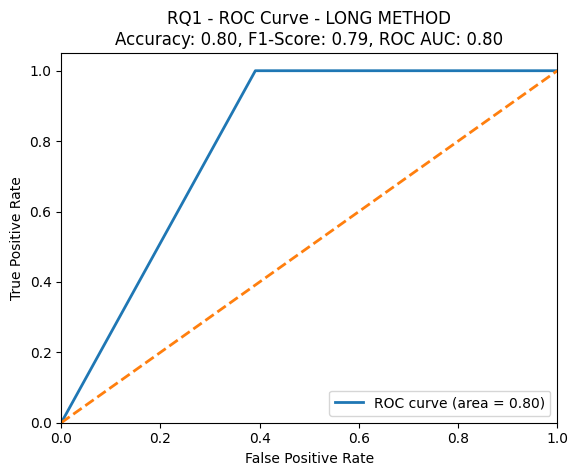


*************************



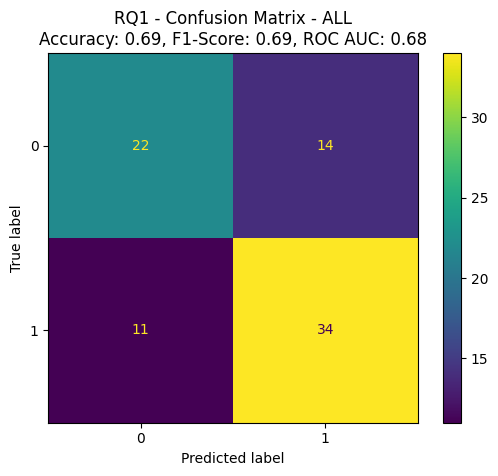

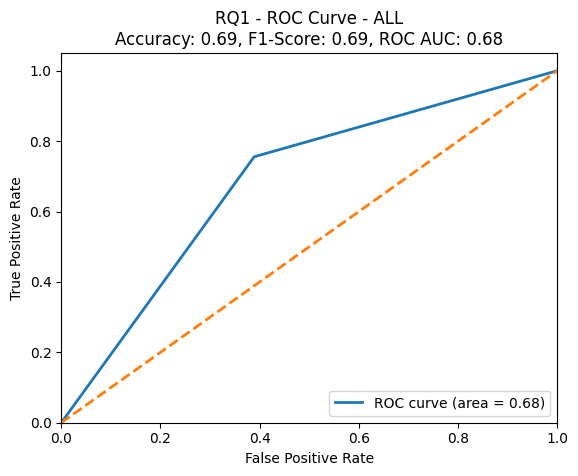


*************************

Summary
              accuracy  f1_score  auc_score
FEATURE ENVY  0.464286  0.455391   0.587500
GOD CLASS     0.888889  0.874074   0.750000
LONG METHOD   0.795455  0.788626   0.804348
ALL           0.691358  0.689627   0.683333


In [69]:
rq_results("RQ1")

## RQ2
What is the performance of an LLM in classifying code smells using metrics as part of the prompt beyond the source code and the code smell definition?

In [70]:
RQ2_DATA_MAP[LONG_METHOD_KEY].columns

Index(['complextype', 'method', 'NOP_method', 'CC_method', 'ATFD_method',
       'FDP_method', 'CM_method', 'MAXNESTING_method', 'LOC_method',
       'CYCLO_method', 'NMCS_method', 'NOLV_method', 'MaMCL_method',
       'NOAV_method', 'LAA_method', 'FANOUT_method', 'CFNAMM_method',
       'ATLD_method', 'CLNAMM_method', 'CINT_method', 'MeMCL_method',
       'CDISP_method', 'NOII_type', 'NOAM_type', 'NOCS_type', 'NOM_type',
       'NMO_type', 'ATFD_type', 'FANOUT_type', 'NOMNAMM_type', 'NOA_type',
       'NIM_type', 'DIT_type', 'LOC_type', 'LOCNAMM_type', 'CFNAMM_type',
       'TCC_type', 'NOPA_type', 'CBO_type', 'RFC_type', 'NOC_type', 'WMC_type',
       'LCOM5_type', 'WOC_type', 'WMCNAMM_type', 'AMW_type', 'AMWNAMM_type',
       'NOCS_package', 'NOMNAMM_package', 'NOI_package', 'LOC_package',
       'NOM_package', 'NOPK_project', 'NOCS_project', 'NOI_project',
       'NOM_project', 'NOMNAMM_project', 'LOC_project', 'isStatic_type',
       'number_private_visibility_attributes',
       

In [71]:
@load_and_save_on_disk("rq2_data", RQ2_DATA_MAP)
def process_rq2_data():
  """
  Processes the RQ2 data.
  """
  return process_llm_classification("RQ2", include_metrics=True)

process_rq2_data()

Loaded DataFrame 'feature_envy' from 'rq2_data/feature_envy.csv'.
Loaded DataFrame 'god_class' from 'rq2_data/god_class.csv'.
Loaded DataFrame 'long_method' from 'rq2_data/long_method.csv'.
*** Processing RQ2
 ** Processing feature_envy...
 ** Processing god_class...
 ** Processing long_method...
Checking stop condition...
 Checking feature_envy
  feature_envy: Number of NaN values in 'llm_classification': 0
 Checking god_class
  god_class: Number of NaN values in 'llm_classification': 0
 Checking long_method
  long_method: Number of NaN values in 'llm_classification': 0


Condition satisfied. Exiting retry loop.
DataFrame 'feature_envy' saved to 'rq2_data/feature_envy.csv'.
DataFrame 'god_class' saved to 'rq2_data/god_class.csv'.
DataFrame 'long_method' saved to 'rq2_data/long_method.csv'.


True

In [72]:
print_random_llm_info("RQ2")

No data available for this RQ or columns not found.


### Results

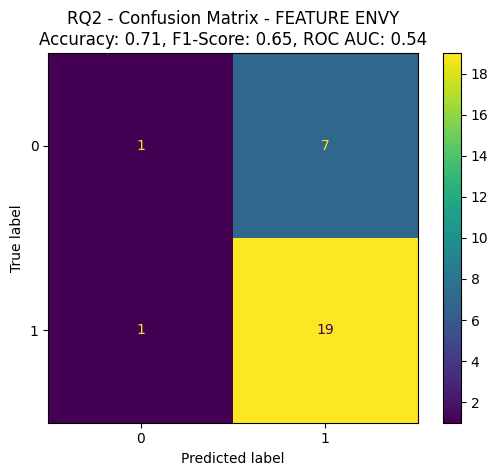

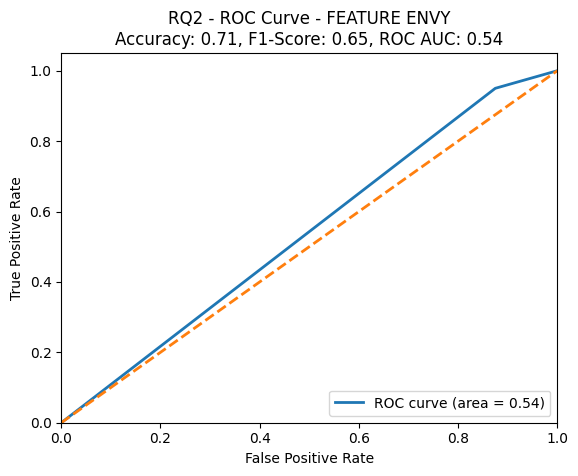


*************************



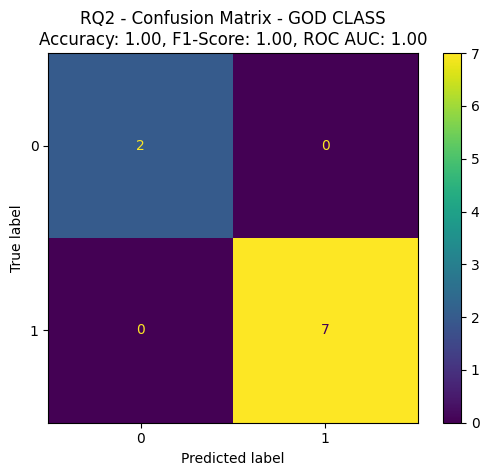

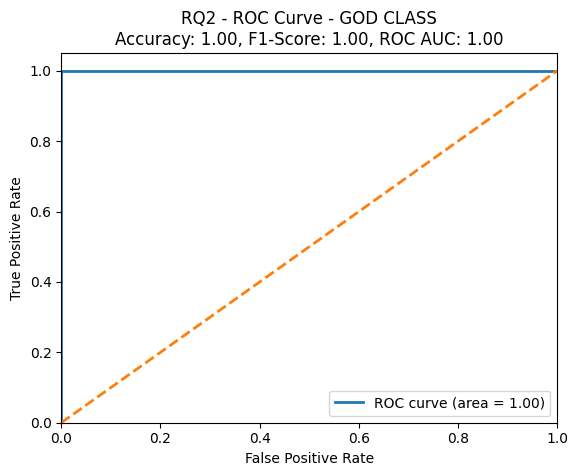


*************************



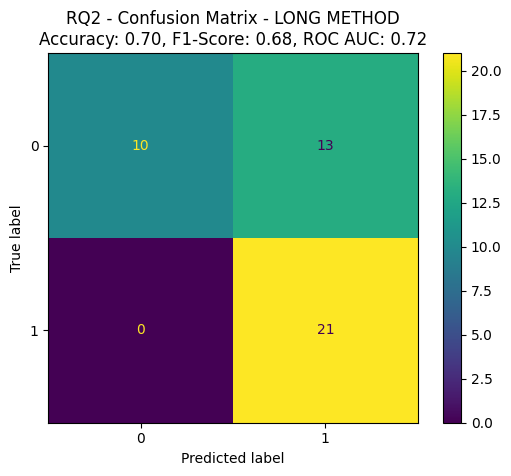

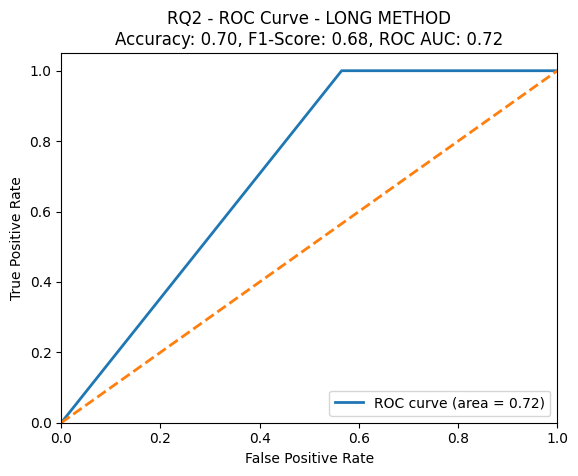


*************************



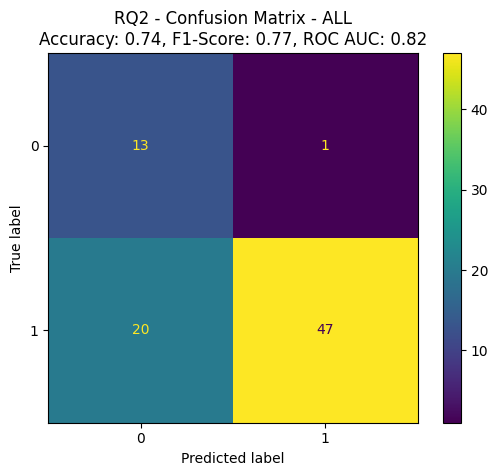

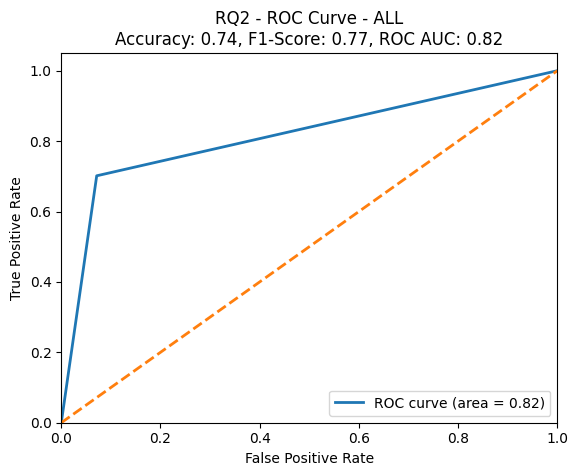


*************************

Summary
              accuracy  f1_score  auc_score
FEATURE ENVY  0.714286  0.647205   0.537500
GOD CLASS     1.000000  1.000000   1.000000
LONG METHOD   0.704545  0.681267   0.717391
ALL           0.740741  0.771727   0.815032


In [73]:
rq_results("RQ2")

## RQ3

In [74]:
# custom hiperparameters
# Lower temperature for deterministic output
TEMPERATURE = 0.3
# Consider only the most likely outputs
TOP_P = 0.9
# Discourage repeating information
FREQUENCY_PENALTY = 0.5
# Slightly encourage introducing new topics
PRESENCE_PENALTY = 0.2

@load_and_save_on_disk("rq3_data", RQ3_DATA_MAP)
def process_rq3_data():
  """
  Processes the RQ3 data.
  """
  return process_llm_classification("RQ3", include_metrics=True,
                                    temperature=TEMPERATURE,
                                    top_p=TOP_P,
                                    frequency_penalty=FREQUENCY_PENALTY,
                                    presence_penalty=PRESENCE_PENALTY
                                    )

process_rq3_data()


Loaded DataFrame 'feature_envy' from 'rq3_data/feature_envy.csv'.
Loaded DataFrame 'god_class' from 'rq3_data/god_class.csv'.
Loaded DataFrame 'long_method' from 'rq3_data/long_method.csv'.
*** Processing RQ3
 ** Processing feature_envy...
 ** Processing god_class...
 ** Processing long_method...
Checking stop condition...
 Checking feature_envy
  feature_envy: Number of NaN values in 'llm_classification': 0
 Checking god_class
  god_class: Number of NaN values in 'llm_classification': 0
 Checking long_method
  long_method: Number of NaN values in 'llm_classification': 0


Condition satisfied. Exiting retry loop.
DataFrame 'feature_envy' saved to 'rq3_data/feature_envy.csv'.
DataFrame 'god_class' saved to 'rq3_data/god_class.csv'.
DataFrame 'long_method' saved to 'rq3_data/long_method.csv'.


True

In [75]:
print_random_llm_info("RQ3")

Random Row:
Code Smell: god_class
llm_user_msg: 
*** SOURCE CODE: BEGIN ***
/*
 * Author jyang Created on 2006-4-5 10:30:53
 */
package com.jasml.decompiler;

import java.util.HashSet;

import com.jasml.classes.Attribute;
import com.jasml.classes.Attribute_Code;
import com.jasml.classes.Attribute_ConstantValue;
import com.jasml.classes.Attribute_Deprecated;
import com.jasml.classes.Attribute_Exceptions;
import com.jasml.classes.Attribute_InnerClasses;
import com.jasml.classes.Attribute_LineNumberTable;
import com.jasml.classes.Attribute_LocalVariableTable;
import com.jasml.classes.Attribute_SourceFile;
import com.jasml.classes.Attribute_Synthetic;
import com.jasml.classes.ConstantPool;
import com.jasml.classes.ConstantPoolItem;
import com.jasml.classes.Constant_Class;
import com.jasml.classes.Constant_Double;
import com.jasml.classes.Constant_Fieldref;
import com.jasml.classes.Constant_Float;
import com.jasml.classes.Constant_Integer;
import com.jasml.classes.Constant_InterfaceMethodre

### Results

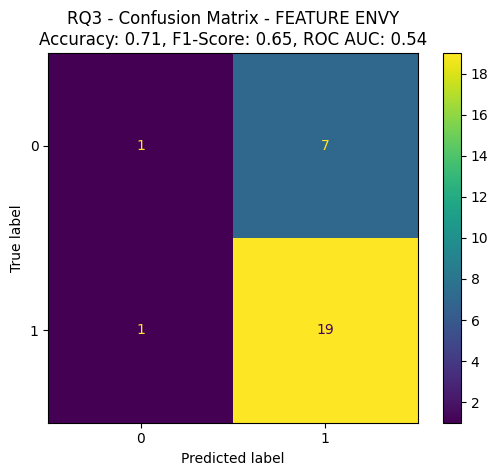

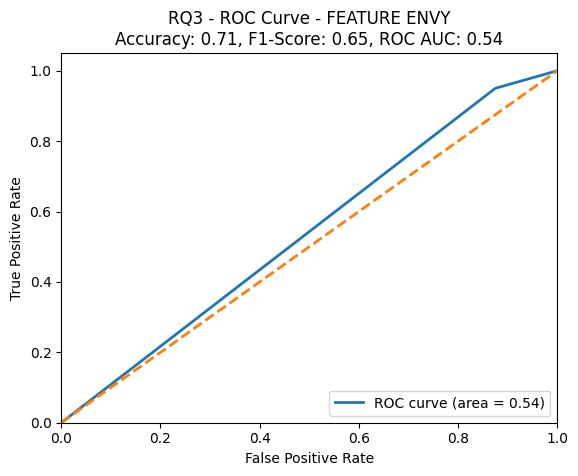


*************************



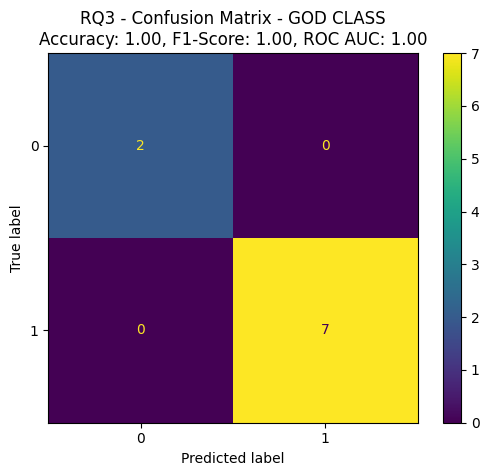

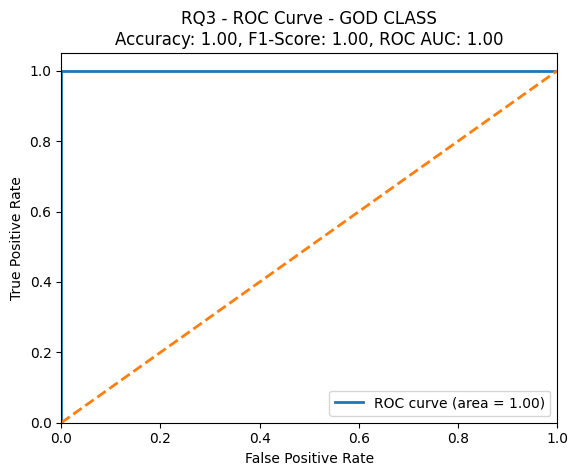


*************************



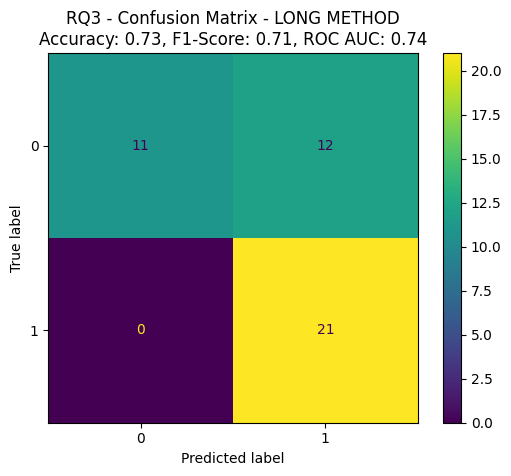

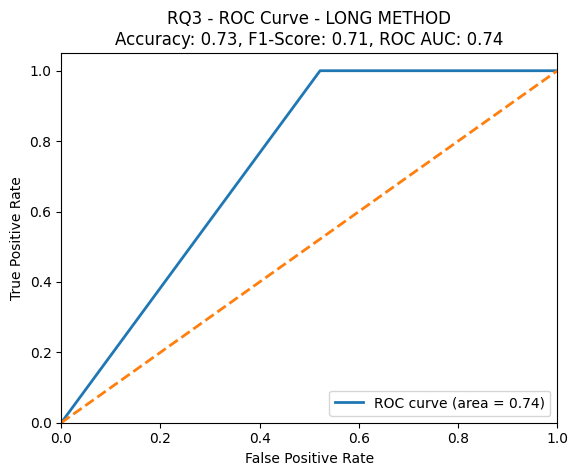


*************************



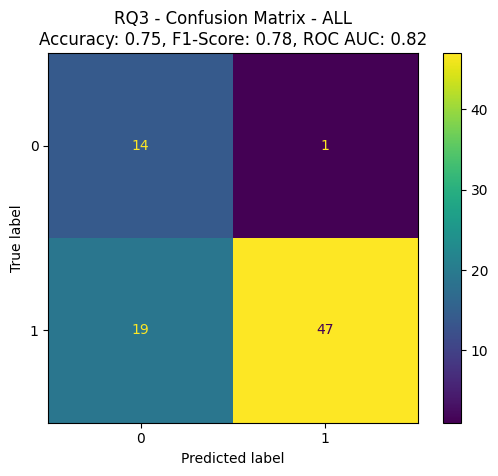

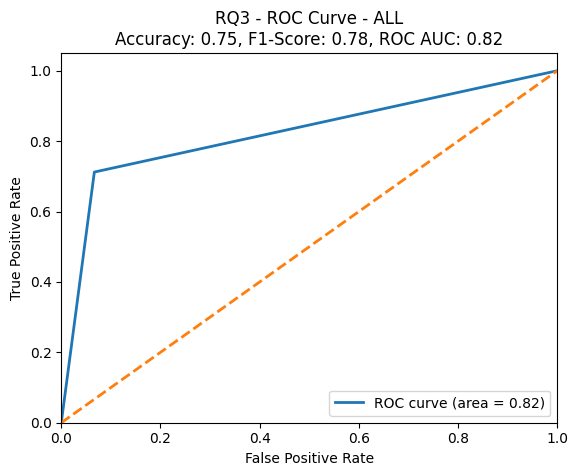


*************************

Summary
              accuracy  f1_score  auc_score
FEATURE ENVY  0.714286  0.647205   0.537500
GOD CLASS     1.000000  1.000000   1.000000
LONG METHOD   0.727273  0.709447   0.739130
ALL           0.753086  0.779890   0.822727


In [76]:
rq_results("RQ3")

## Checking NaN values

In [77]:
# for each experiment in EXPERIMENT_DATA_MAP,
# checking the number of NaN values for the "llm_classification" field

for rq_key, rq_map in EXPERIMENTS_DATA_MAP.items():
  print(f"Processing {rq_key}...")
  for code_smell_name, df in rq_map.items():
    nan_count = df['llm_classification'].isna().sum()
    print(f"  {code_smell_name}: Number of NaN values in 'llm_classification': {nan_count}")
  print("\n")

Processing RQ0...
  feature_envy: Number of NaN values in 'llm_classification': 0
  god_class: Number of NaN values in 'llm_classification': 0
  long_method: Number of NaN values in 'llm_classification': 0


Processing RQ1...
  feature_envy: Number of NaN values in 'llm_classification': 0
  god_class: Number of NaN values in 'llm_classification': 0
  long_method: Number of NaN values in 'llm_classification': 0


Processing RQ2...
  feature_envy: Number of NaN values in 'llm_classification': 0
  god_class: Number of NaN values in 'llm_classification': 0
  long_method: Number of NaN values in 'llm_classification': 0


Processing RQ3...
  feature_envy: Number of NaN values in 'llm_classification': 0
  god_class: Number of NaN values in 'llm_classification': 0
  long_method: Number of NaN values in 'llm_classification': 0




## Summary Table

In [78]:
def transform_results_to_table(results_data_map):
    """
    Transforms the RESULTS_DATA_MAP dictionary into the format of Table II.

    Parameters:
        results_data_map (dict): Dictionary containing the results for each RQ.

    Returns:
        pd.DataFrame: DataFrame formatted like Table II.
    """
    # Initialize a list to hold rows of the final table
    rows = []

    # Iterate over each RQ in RESULTS_DATA_MAP
    for rq, df in results_data_map.items():
      # Iterate over each code smell in the DataFrame
      for code_smell, metrics in df.iterrows():
        # Append each row as a dictionary
        rows.append({
            "Code Smell": code_smell.replace("_", " ").title(),
            "Metric": "F1-Score",
            "RQ": rq,
            "Value": metrics['f1_score']
        })
        rows.append({
            "Code Smell": code_smell.replace("_", " ").title(),
            "Metric": "AUC",
            "RQ": rq,
            "Value": metrics['auc_score']
        })
        rows.append({
            "Code Smell": code_smell.replace("_", " ").title(),
            "Metric": "Accuracy",
            "RQ": rq,
            "Value": metrics['accuracy']
        })

    # Convert the list of rows into a DataFrame
    table_df = pd.DataFrame(rows)

    # Pivot the table to have RQs as columns and metrics as rows
    pivot_table = table_df.pivot_table(index=["Code Smell", "Metric"], columns="RQ", values="Value")

    return pivot_table


SUMMARY_TABLE = transform_results_to_table(RESULTS_DATA_MAP)

# saving the SUMMARY_TABLE as a csv on disk
SUMMARY_TABLE.to_csv("summary_table.csv")

SUMMARY_TABLE

RQ                          RQ0       RQ1       RQ2       RQ3
Code Smell   Metric                                          
All          AUC       0.518634  0.683333  0.815032  0.822727
             Accuracy  0.530864  0.691358  0.740741  0.753086
             F1-Score  0.528956  0.689627  0.771727  0.779890
Feature Envy AUC       0.500000  0.587500  0.537500  0.537500
             Accuracy  0.285714  0.464286  0.714286  0.714286
             F1-Score  0.126984  0.455391  0.647205  0.647205
God Class    AUC       0.750000  0.750000  1.000000  1.000000
             Accuracy  0.888889  0.888889  1.000000  1.000000
             F1-Score  0.874074  0.874074  1.000000  1.000000
Long Method  AUC       0.630435  0.804348  0.717391  0.739130
             Accuracy  0.613636  0.795455  0.704545  0.727273
             F1-Score  0.556054  0.788626  0.681267  0.709447

## Metrics Evolution Plots

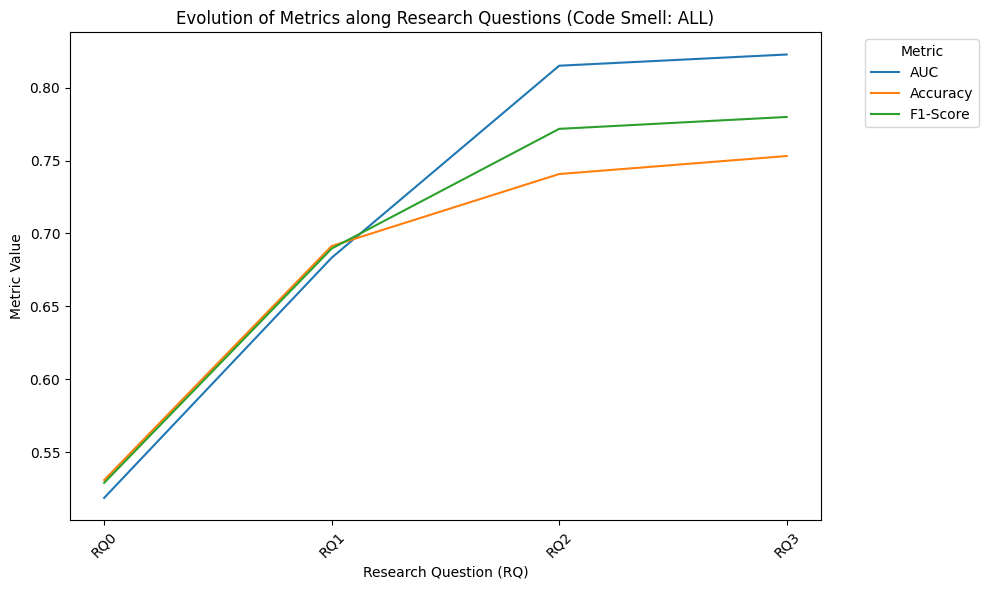

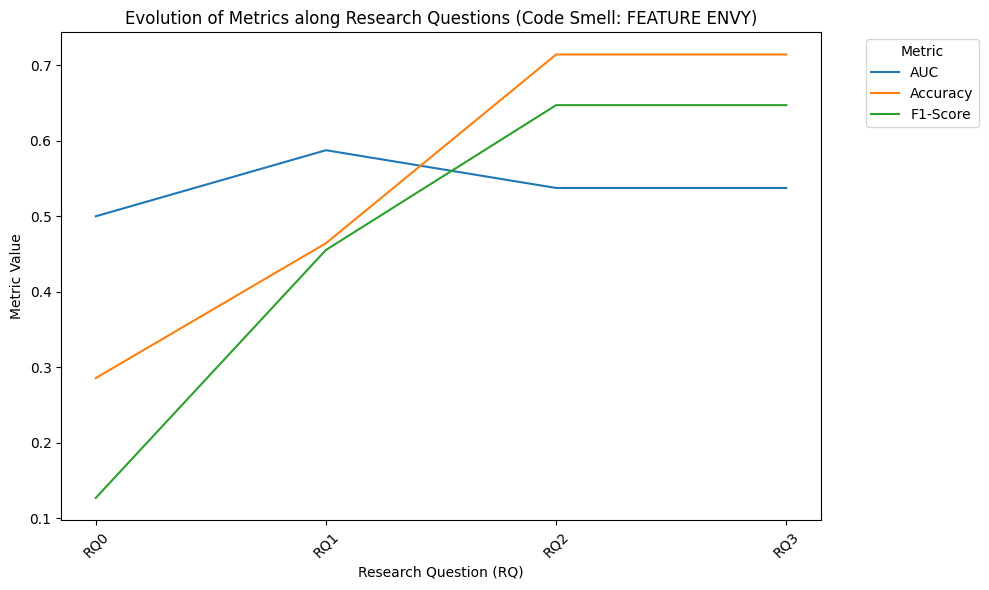

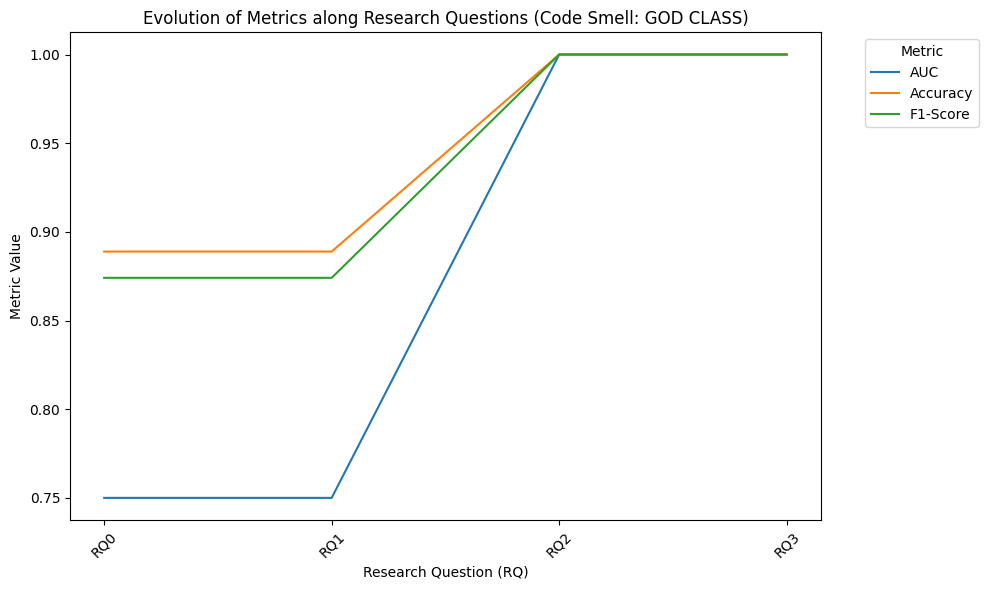

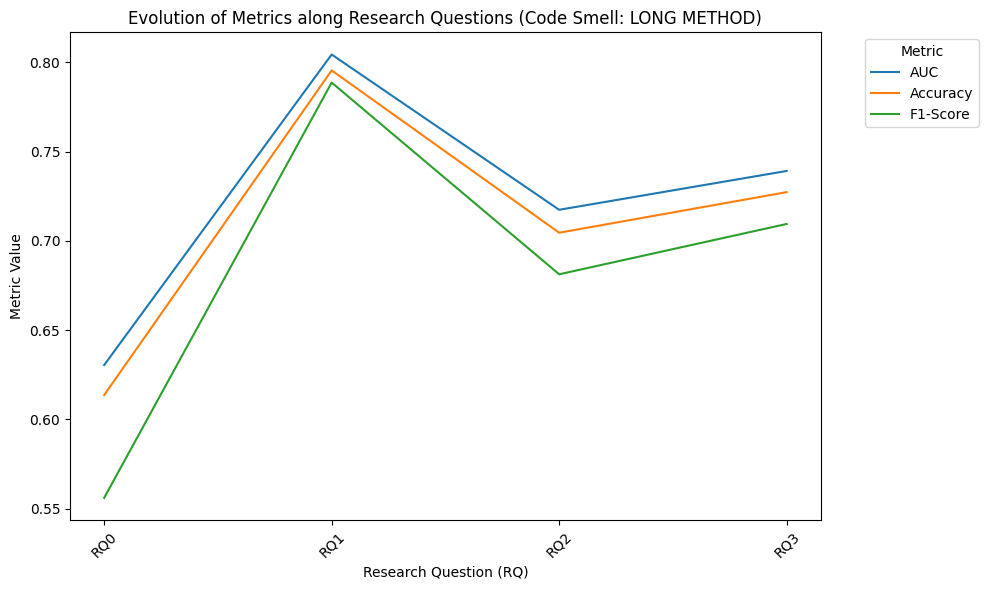

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics_for_code_smell(summary_table, code_smell):
    """
    Plots the evolution of metrics along research questions for a specific code smell.

    Parameters:
        summary_table (pd.DataFrame): The DataFrame containing metrics for all code smells.
        code_smell (str): The specific code smell to filter and plot (e.g., 'All', 'Feature Envy').
    """
    # Reshape the data for plotting
    df_long = pd.melt(summary_table.reset_index(),
                      id_vars=['Code Smell', 'Metric'],
                      var_name='RQ',
                      value_name='Value')

    # Filter to include only the specified code smell and create a copy to avoid SettingWithCopyWarning
    df_long_filtered = df_long[df_long['Code Smell'] == code_smell].copy()

    # Convert RQ to categorical for consistent ordering
    df_long_filtered.loc[:, 'RQ'] = pd.Categorical(
        df_long_filtered['RQ'], categories=['RQ0', 'RQ1', 'RQ2', 'RQ3'], ordered=True
    )

    # Create the line plot
    plt.figure(figsize=(10, 6))

    # Iterate through each metric for the specified code smell
    for metric in df_long_filtered['Metric'].unique():
        subset = df_long_filtered[df_long_filtered['Metric'] == metric].dropna(subset=['Value'])
        plt.plot(subset['RQ'], subset['Value'], label=f"{metric}")

    # Configure plot labels and legend
    plt.xlabel('Research Question (RQ)')
    plt.ylabel('Metric Value')
    plt.title(f'Evolution of Metrics along Research Questions (Code Smell: {code_smell.upper()})')
    plt.xticks(rotation=45)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    print("\n")

plot_metrics_for_code_smell(SUMMARY_TABLE, 'All')  # Plot metrics for the 'All' category
plot_metrics_for_code_smell(SUMMARY_TABLE, 'Feature Envy')  # Plot metrics for 'Feature Envy'
plot_metrics_for_code_smell(SUMMARY_TABLE, 'God Class')  # Plot metrics for 'God Class'
plot_metrics_for_code_smell(SUMMARY_TABLE, 'Long Method')  # Plot metrics for 'Long Method'


## Best Results

In [80]:
# Find the best results, considering each metric

def find_best_results(summary_table):
    """
    Finds the best results for each code smell and metric across all RQs.

    Args:
        summary_table (pd.DataFrame): The summary table containing metrics for each RQ.

    Returns:
        pd.DataFrame: A DataFrame containing the best results for each code smell and metric.
    """
    best_results = []

    for code_smell in summary_table.index.get_level_values('Code Smell').unique():
        for metric in summary_table.index.get_level_values('Metric').unique():
            try:
                # Get the relevant data
                subset = summary_table.loc[(code_smell, metric), :]

                # Find the RQ with the highest value
                best_rq = subset.idxmax()
                best_value = subset.max()

                # Append the result as a dictionary
                best_results.append({
                    'Code Smell': code_smell,
                    'Metric': metric,
                    'Best RQ': best_rq,
                    'Best Value': best_value
                })

            except (ValueError, KeyError):
                # Handles cases where there's no data for a particular code smell and metric combination
                print(f"No data found for {code_smell} and {metric}")
                continue  # Skip to the next iteration

    # Create a DataFrame from the list of results
    best_results_df = pd.DataFrame(best_results)

    return best_results_df

BEST_RESULTS_DF = find_best_results(SUMMARY_TABLE)
BEST_RESULTS_DF

,Code Smell,Metric,Best RQ,Best Value
0,All,AUC,RQ3,0.822727
1,All,Accuracy,RQ3,0.753086
2,All,F1-Score,RQ3,0.779890
3,Feature Envy,AUC,RQ1,0.587500
4,Feature Envy,Accuracy,RQ2,0.714286
5,Feature Envy,F1-Score,RQ2,0.647205
6,God Class,AUC,RQ2,1.000000
7,God Class,Accuracy,RQ2,1.000000
8,God Class,F1-Score,RQ2,1.000000
9,Long Method,AUC,RQ1,0.804348


## Error Analysis

METHODOLOGIC DECISION: For the "Error Analysis," we analyzed the data regarding the best results for all code smells using the AUC score metric.

In [81]:
# Assuming BEST_RESULTS_DF is already defined as in the provided code.
def find_best_rq_for_metric(df, code_smell, metric):
  """
  Finds the best RQ for a given code smell and metric by iterating over the DataFrame.

  Args:
      df (pd.DataFrame): The DataFrame containing the results.
      code_smell (str): The code smell to filter by.
      metric (str): The metric to filter by.

  Returns:
      str: The best RQ or None if no match is found.
  """
  best_rq = None
  best_value = float('-inf')  # Initialize to negative infinity

  def _compare_strings(s1, s2, case_insensitive=True):
    s1 = str(s1)
    s2 = str(s2)
    if case_insensitive:
        return s1.lower() == s2.lower()
    else:
        return s1 == s2

  # Iterate over the rows of the DataFrame
  for _, row in df.iterrows():
    if _compare_strings(row['Code Smell'], code_smell) and _compare_strings(row['Metric'], metric):
      # Check if the current row has a higher 'Best Value'
      if row['Best Value'] > best_value:
        best_rq = row['Best RQ']
        best_value = row['Best Value']

  return best_rq  # Return the best RQ found, or None if no match

# Find the best RQ for "ALL" code smell and "AUC" metric
BEST_RQ_ALL_AUC = find_best_rq_for_metric(BEST_RESULTS_DF, "ALL", "AUC")

print(f"The best RQ for code smell 'ALL' and metric 'AUC' is: {BEST_RQ_ALL_AUC}")

The best RQ for code smell 'ALL' and metric 'AUC' is: RQ3


In [82]:
BEST_EXPERIMENT_MAP = EXPERIMENTS_DATA_MAP[BEST_RQ_ALL_AUC]
BEST_EXPERIMENT_MAP.keys()

dict_keys(['feature_envy', 'god_class', 'long_method'])

In [83]:
# Assuming BEST_EXPERIMENT_MAP is defined as in the provided code.
def analyze_errors(best_experiment_map):
    """
    Analyzes prediction errors for each code smell in the best experiment.

    Args:
        best_experiment_map (dict): A dictionary where keys are code smell names and values are corresponding DataFrames.

    Returns:
        pd.DataFrame: A DataFrame containing all errors in the predictions.
    """

    all_errors_df = pd.DataFrame()

    for code_smell_name, df in best_experiment_map.items():
        # Identify incorrect predictions
        errors_df = df[df['is_' + code_smell_name] != df['llm_classification']].copy()

        allowed_cols = ['llm_classification']

        # excluding all other cols that has no "code_smell_name" in its name
        errors_df = errors_df[[col for col in errors_df.columns if (code_smell_name in col or col in allowed_cols)]]

        # renaming the cols 'is_' + code_smell_name and 'llm_classification' to 'y_true' and 'y_pred'
        errors_df.rename(columns={'is_' + code_smell_name: 'y_true',
                                  'llm_classification': 'y_pred'},
                         inplace=True)

        # renaming all cols with "code_smell_name" as part of its name, replacing "code_smell_name" by "y_true"
        for col in errors_df.columns:
            if code_smell_name in col:
                errors_df.rename(columns={col: col.replace(code_smell_name, 'code_smell')}, inplace=True)

        # Add a column to indicate the code smell
        errors_df['code_smell'] = code_smell_name

        # y_true_confidence is the max of the is_code_smell_count_negative and is_code_smell_count_positive divides by the is_code_smell_count
        errors_df['y_true_confidence'] = errors_df[['is_code_smell_count_negative', 'is_code_smell_count_positive']].max(axis=1) / errors_df['is_code_smell_count']

        # y_true_confidence_level must me HIGH, if y_true_confidence is above 0.85
        # must be MEDIUM if between 0.7 and 0.85
        # and must be LOW if below 0.7
        errors_df['y_true_confidence_level'] = errors_df['y_true_confidence'].apply(lambda x: 'HIGH' if x > 0.85 else ('MEDIUM' if 0.7 < x < 0.85 else 'LOW'))

        # excluding and ordering the cols in a convenient way
        errors_df = errors_df[['code_smell', 'is_code_smell_count', 'is_code_smell_count_negative', 'is_code_smell_count_positive', 'y_true', 'y_pred', 'y_true_confidence', 'y_true_confidence_level']]

        # Concatenate errors to the overall errors dataframe
        all_errors_df = pd.concat([all_errors_df, errors_df], ignore_index=True)

    return all_errors_df

# Example usage (assuming BEST_EXPERIMENT_MAP is defined)
errors_df = analyze_errors(BEST_EXPERIMENT_MAP)
errors_df

,code_smell,is_code_smell_count,is_code_smell_count_negative,is_code_smell_count_positive,y_true,y_pred,y_true_confidence,y_true_confidence_level
0,feature_envy,1,1,0,False,True,1.000000,HIGH
1,feature_envy,11,6,5,False,True,0.545455,LOW
2,feature_envy,11,7,4,False,True,0.636364,LOW
3,feature_envy,1,1,0,False,True,1.000000,HIGH
4,feature_envy,1,1,0,False,True,1.000000,HIGH
5,feature_envy,1,1,0,False,True,1.000000,HIGH
6,feature_envy,1,1,0,False,True,1.000000,HIGH
7,feature_envy,2,0,2,True,False,1.000000,HIGH
8,long_method,38,36,2,False,True,0.947368,HIGH
9,long_method,44,42,2,False,True,0.954545,HIGH


In [85]:
# saving the erros_df as a csv file
errors_df.to_csv('errors_data.csv', index=False)